# dependencies

In [1]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.8 MB/s eta 0:00:00a 0:00:01


In [2]:
import os
import shutil
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from monai.transforms import ( Transform,
    Compose, LoadImaged, Spacingd, Orientationd, RandAffine,Resized,EnsureTyped,
    RandFlip, Rand3DElastic, RandGaussianNoise, RandAdjustContrastd, RandGaussianSharpend,
    RandSpatialCropd, RandCoarseDropout, RandGaussianSmooth, ToTensord
)
from monai.data import MetaTensor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

labels = pd.read_csv('/kaggle/input/raw-gray-volumes/labels.csv')
labels

/opt/conda/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


,SeriesInstanceUID,labels,image_weight,patientID,weight,age,sex,orientation,slice_num
0,1.3.46.670589.11.10042.5.0.6048.20240307143704...,0,T2W_TSE,682154,52,53,F,TRANSVERSAL,16
1,1.3.46.670589.11.10042.5.0.6048.20240307143746...,0,T1W_SE,682154,52,53,F,TRANSVERSAL,16
2,1.3.46.670589.11.10042.5.0.6048.20240307143846...,0,T2W_FLAIR,682154,52,53,F,TRANSVERSAL,16
3,1.3.46.670589.11.10042.5.0.4776.20240217030800...,0,T2W_TSE,657035,80,63,F,TRANSVERSAL,18
4,1.3.46.670589.11.10042.5.0.4776.20240217030846...,0,T1W_SE,657035,80,63,F,TRANSVERSAL,18
...,...,...,...,...,...,...,...,...,...
3127,1.3.46.670589.11.10042.5.0.6596.20240121010846...,0,T1W_SE,682442,75,43,M,TRANSVERSAL,18
3128,1.3.46.670589.11.10042.5.0.6596.20240121011007...,0,T2W_FLAIR,682442,75,43,M,TRANSVERSAL,18
3129,1.3.46.670589.11.10042.5.0.6596.20240121015623...,0,T2W_TSE,682259,75,42,F,TRANSVERSAL,18
3130,1.3.46.670589.11.10042.5.0.6596.20240121015906...,0,T2W_FLAIR,682259,75,42,F,TRANSVERSAL,18


In [3]:
import torch
from monai.transforms import MapTransform

class AdjustBrightnessd(MapTransform):
    def __init__(self, keys, brightness_factor=1.0):
        super().__init__(keys)
        self.brightness_factor = brightness_factor

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            img = d[key]

            # Adjust brightness directly on the tensor
            if isinstance(img, torch.Tensor):
                img = img * self.brightness_factor
                img = torch.clamp(img, 0, 1)  # Ensure values stay within [0, 1]
            else:
                raise TypeError("Expected image to be a torch.Tensor.")

            d[key] = img
        return d


In [4]:
def prepare_Dataloader(modality, batch_size, num_channels=3, split_ratio=0.2, augment=False, spatial_size=(32, 256, 256)):
    labels = pd.read_csv('/kaggle/input/raw-gray-volumes/labels.csv')
    labels = labels[labels['orientation'] == 'TRANSVERSAL']
    labels = labels[labels['slice_num'] >= 16]
    labels.loc[labels['age'] > 100, 'age'] -= 100

    modality_df = labels[labels['image_weight'] == modality]

    scaler = StandardScaler()
    modality_df = modality_df.copy()
    modality_df[['age', 'weight']] = scaler.fit_transform(modality_df[['age', 'weight']])


    modality_path = f'/kaggle/working/{modality}'
    os.makedirs(modality_path, exist_ok=True)

    for suid in modality_df['SeriesInstanceUID']:
      shutil.copy(f'/kaggle/input/raw-gray-volumes/gray_volumes/content/gray_volume/{suid}.npy', f'{modality_path}/{suid}.npy')

    labels_dict = modality_df.set_index('SeriesInstanceUID')['labels'].to_dict()

    meta_data_dict = {}
    for index, row in modality_df.iterrows():
      meta_data_dict[row['SeriesInstanceUID']] = [row['age'], row['weight']]

    class BrainMRIDataset(Dataset):
        def __init__(self, npy_dir, labels_dict=labels_dict, meta_data_dict=meta_data_dict, transform=None):
            self.npy_dir = npy_dir
            self.labels_dict = labels_dict
            self.meta_data_dict = meta_data_dict
            self.transform = transform
            self.filenames = list(labels_dict.keys())
            self.class_sample_counts = np.bincount(list(self.labels_dict.values()))

        def __len__(self):
            return len(self.filenames)

        def __getitem__(self, idx):
            filename = self.filenames[idx]
            label = self.labels_dict[filename]
            meta_data = self.meta_data_dict[filename]

            npy_path = os.path.join(self.npy_dir, f"{filename}.npy")
            image = np.load(npy_path)

            if num_channels == 1:
                image = np.expand_dims(image, axis=0)
            elif num_channels ==3:
                image = np.stack([image] * 3, axis=0)

            meta_data = torch.tensor(meta_data, dtype=torch.float32)
            sample = {'image': image,   'label': label,   'meta_data':meta_data}

            # Apply transforms if any
            if self.transform:
                sample = self.transform(sample)

            return sample

    if augment == False:
            transforms = Compose([ Resized(keys=['image'],spatial_size=spatial_size), EnsureTyped(keys=['image']) ])

    elif augment == True:
            transforms = Compose([  Resized(keys=['image'],spatial_size=spatial_size), EnsureTyped(keys=['image']),
                    RandAdjustContrastd(keys=['image'], gamma=(1.2), prob=1.0), AdjustBrightnessd(keys=["image"], brightness_factor=1.2), # Spacingd(keys=['image'], pixdim = (1.0, 1.0, 1.0)),
                                                                                                                                               ])

    full_dataset = BrainMRIDataset(modality_path, labels_dict=labels_dict, meta_data_dict=meta_data_dict, transform=transforms)

    train_indices, val_indices = train_test_split(np.arange(len(full_dataset)), test_size=split_ratio, stratify=list(labels_dict.values()))

    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    data_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)
    # Example: Iterate through the dataloader
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    for batch in val_loader:
        images = batch['image']  # shape [batch_size, channels, 18, 256, 256]
        labels = batch['label']  # shape [batch_size]
        print(images.shape, labels)

        for i in range(min(32, images.shape[2])):
            row = i // 8
            col = i % 8
            axes[row, col].imshow(images[0, 0, i, :, :].cpu().numpy(), cmap='gray')
            axes[row, col].axis('off')

        plt.tight_layout()
        plt.show()
        break  # Stop after the first batch

    class_sample_counts = full_dataset.class_sample_counts
    class_weights = 1. / class_sample_counts
    class_weights = torch.FloatTensor(class_weights)

    return data_loader, train_loader, val_loader, class_weights

## Densnet

### from scratch

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        if alpha is not None:
            self.alpha = torch.tensor(alpha)  # Store alpha as a tensor
        else:
            self.alpha = None

    def forward(self, inputs, targets):
        # Apply sigmoid to inputs as we're assuming raw logits
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        # Convert logits to probabilities
        pt = torch.exp(-BCE_loss)  # pt is the probability of the true class

        # If alpha (class weight) is provided, apply it
        if self.alpha is not None:
            # Move alpha to the same device as targets
            alpha_t = self.alpha.to(targets.device) * targets + (1 - self.alpha.to(targets.device)) * (1 - targets)
            BCE_loss = alpha_t * BCE_loss

        # Focal loss calculation with gamma factor
        F_loss = (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss


In [6]:
from monai.networks.nets import DenseNet264
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from tqdm import tqdm


def densnet_from_scratch(data_loader, train_loader, val_loader, class_weights):

    model = DenseNet264(
                                        spatial_dims=3,
                                        in_channels=1,
                                        #growth_rate=40,
                                        #block_config=(16, 64, 64, 4), # (6, 12, 64, 48)
                                        out_channels=2,
                                        #init_features=64,
                                        dropout_prob=0.15
                                                                     )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    class_weights = class_weights.to(device)

    def calculate_metrics(predictions, labels):
        y_true = np.array(labels)
        y_pred = np.array(predictions)
        if y_true.ndim > 1:
            y_true = np.argmax(y_true, axis=1)
        if y_pred.ndim > 1:
            y_pred = np.argmax(y_pred, axis=1)
        auc = roc_auc_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred.round(), average='binary', zero_division=1)
        recall = recall_score(y_true, y_pred.round(), average='binary', zero_division=1)

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        print('-------->   tn:',tn,'  ---   fp:', fp,' ---   fn:', fn,' ---   tp:', tp)

        return (auc + (precision + recall)/2)/2

    alpha = [0.12, 0.88]
    criterion = FocalLoss(alpha=alpha, gamma=1.0, reduction='sum')
    #criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    torch.cuda.empty_cache()
    best_checkpoint_path = f'/kaggle/working/{modality}.pth'
    if os.path.exists(best_checkpoint_path):
        print('loading checkpoint ...')
        checkpoint = torch.load(best_checkpoint_path)
        model.load_state_dict(checkpoint)
        model.eval()
        val_running_loss = 0.0
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch in data_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device)
                labels = torch.nn.functional.one_hot(labels.long(), num_classes=2).float().to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_predictions.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

            val_predictions = np.array(val_predictions)
            val_labels = np.array(val_labels)
            best_metric = calculate_metrics(val_predictions, val_labels)
            print(f"whole dataset Loss: {val_running_loss/len(data_loader):.5f}   ,   custom metric: {best_metric:.5f}")
    else:
        best_metric = 0.0


    num_epochs = 60
    for epoch in tqdm(range(num_epochs),'epoching ...'):
        print(f"Epoch [{epoch+1}/{num_epochs}]  -  Learning Rate = {optimizer.param_groups[0]['lr']}")
        model.train()
        running_loss = 0.0
        all_predictions = []
        all_labels = []

        for batch in train_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            labels = torch.nn.functional.one_hot(labels.long(), num_classes=2).float().to(device)


            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Collect predictions and labels
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Convert lists to numpy arrays
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)

        print(f"Training Loss: {running_loss/len(train_loader):.5f}   ,   custom metric: {calculate_metrics(all_predictions, all_labels):.5f}")
        # Calculate metrics for the current epoch

        model.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device)
                labels = torch.nn.functional.one_hot(labels.long(), num_classes=2).float().to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_predictions.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

            val_predictions = np.array(val_predictions)
            val_labels = np.array(val_labels)
            val_c_metric = calculate_metrics(val_predictions, val_labels)
            print(f"Validation Loss: {val_running_loss/len(val_loader):.5f}   ,   custom metric: {val_c_metric:.5f}")

            if val_c_metric > best_metric:
                  best_metric = val_c_metric
                  torch.save(model.state_dict(), best_checkpoint_path)              # Save the model
                  print("                                           <<< ==== Saved new best model ==== >>>")

            print('-------------------------------------------------------------------------------------')
    return model
    print("Finished Training")

In [ ]:
modality = 'T2W_TSE'
data_loader, train_loader, val_loader, class_weights = prepare_Dataloader(modality, batch_size=12, num_channels=1, spatial_size=(32, 128, 128), split_ratio=0.1)

torch.Size([12, 1, 32, 128, 128]) tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1])


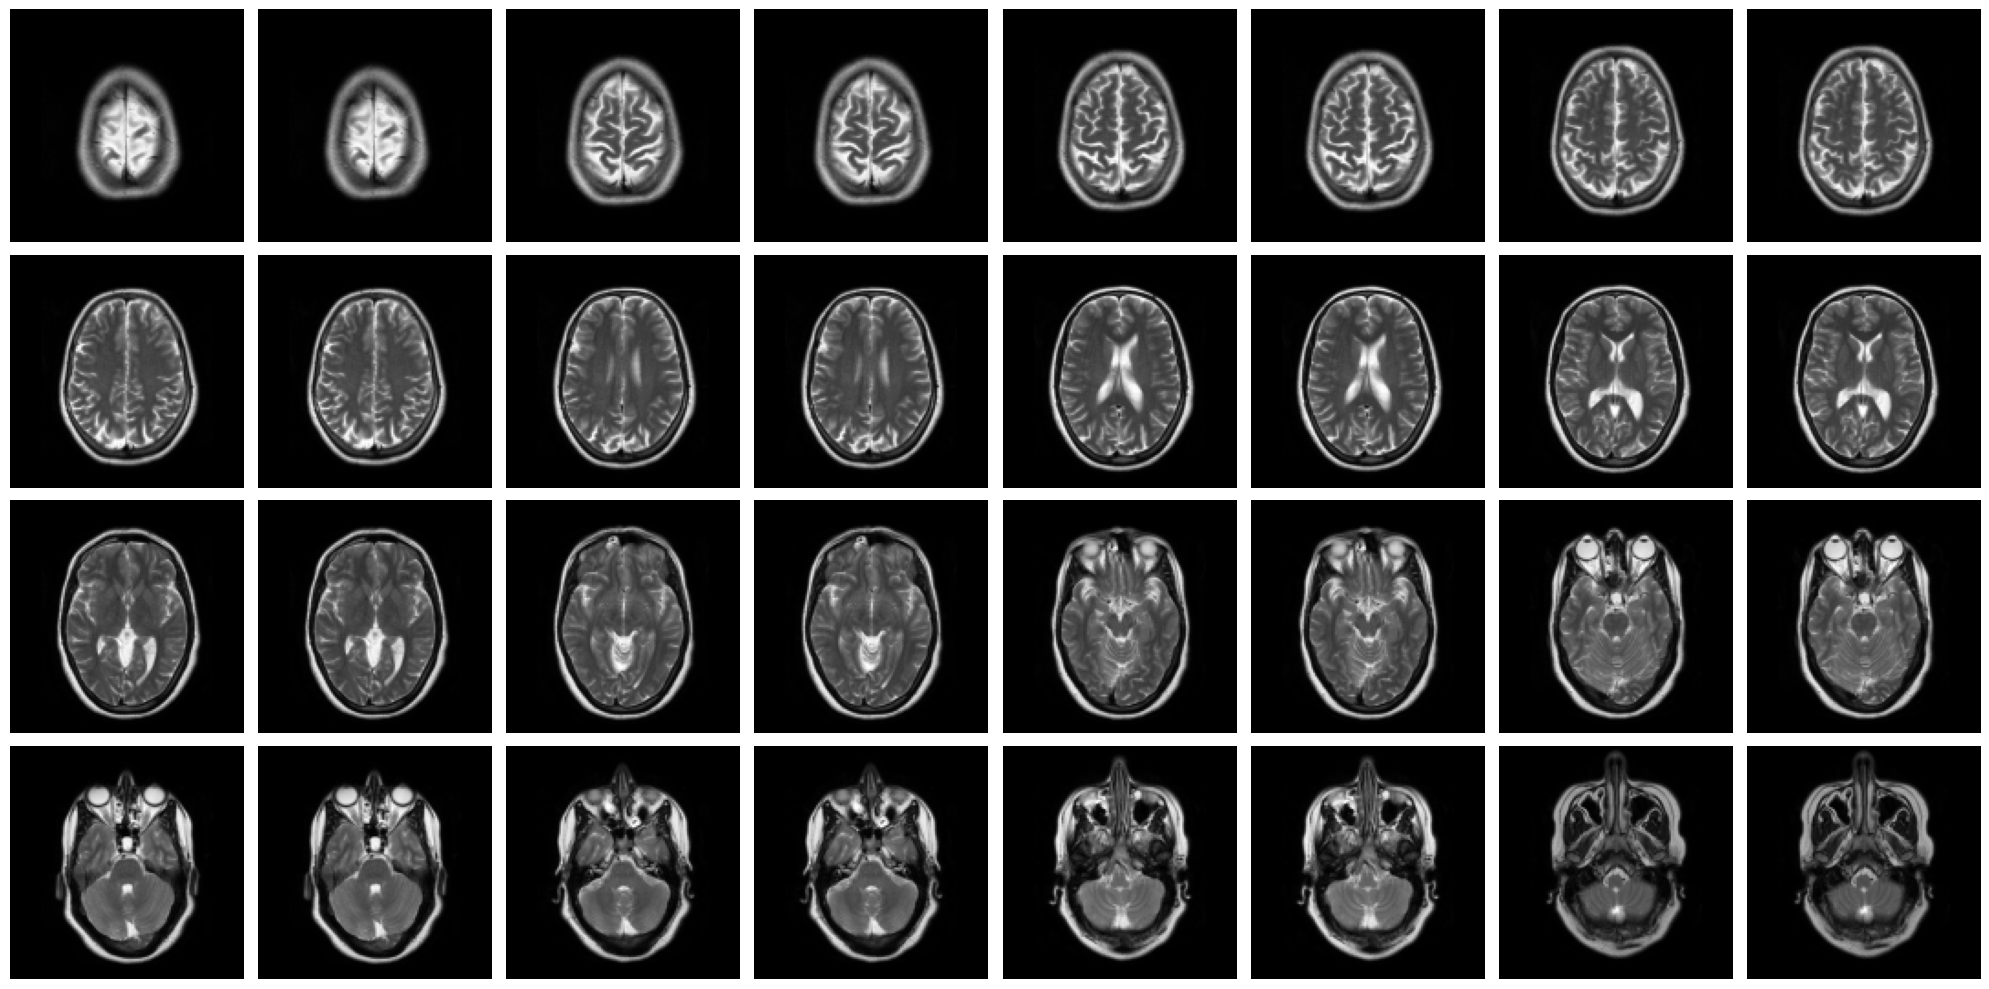

epoching ...:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1/60]  -  Learning Rate = 5e-05
-------->   tn: 498   ---   fp: 320  ---   fn: 44  ---   tp: 76
Training Loss: 1.70675   ,   custom metric: 0.51685
-------->   tn: 88   ---   fp: 4  ---   fn: 11  ---   tp: 2
Validation Loss: 1.77882   ,   custom metric: 0.39939


epoching ...:   2%|▏         | 1/60 [01:09<1:08:38, 69.80s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [2/60]  -  Learning Rate = 5e-05
-------->   tn: 527   ---   fp: 291  ---   fn: 41  ---   tp: 79
Training Loss: 1.63190   ,   custom metric: 0.54361
-------->   tn: 87   ---   fp: 5  ---   fn: 10  ---   tp: 3
Validation Loss: 1.95818   ,   custom metric: 0.44555


epoching ...:   3%|▎         | 2/60 [02:18<1:06:37, 68.92s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [3/60]  -  Learning Rate = 5e-05
-------->   tn: 573   ---   fp: 245  ---   fn: 54  ---   tp: 66
Training Loss: 1.69960   ,   custom metric: 0.50318
-------->   tn: 92   ---   fp: 0  ---   fn: 12  ---   tp: 1
Validation Loss: 2.25923   ,   custom metric: 0.53846


epoching ...:   5%|▌         | 3/60 [03:27<1:05:37, 69.07s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [4/60]  -  Learning Rate = 5e-05
-------->   tn: 563   ---   fp: 255  ---   fn: 47  ---   tp: 73
Training Loss: 1.63860   ,   custom metric: 0.53187


epoching ...:   7%|▋         | 4/60 [04:36<1:04:31, 69.13s/it]

-------->   tn: 91   ---   fp: 1  ---   fn: 11  ---   tp: 2
Validation Loss: 2.16545   ,   custom metric: 0.49087
-------------------------------------------------------------------------------------
Epoch [5/60]  -  Learning Rate = 5e-05
-------->   tn: 541   ---   fp: 277  ---   fn: 45  ---   tp: 75
Training Loss: 1.63073   ,   custom metric: 0.53111


epoching ...:   8%|▊         | 5/60 [05:45<1:03:23, 69.16s/it]

-------->   tn: 92   ---   fp: 0  ---   fn: 12  ---   tp: 1
Validation Loss: 2.68560   ,   custom metric: 0.53846
-------------------------------------------------------------------------------------
Epoch [6/60]  -  Learning Rate = 5e-05
-------->   tn: 555   ---   fp: 263  ---   fn: 49  ---   tp: 71
Training Loss: 1.69299   ,   custom metric: 0.51860


epoching ...:  10%|█         | 6/60 [06:55<1:02:16, 69.19s/it]

-------->   tn: 89   ---   fp: 3  ---   fn: 10  ---   tp: 3
Validation Loss: 1.88817   ,   custom metric: 0.48223
-------------------------------------------------------------------------------------
Epoch [7/60]  -  Learning Rate = 5e-05
-------->   tn: 529   ---   fp: 289  ---   fn: 36  ---   tp: 84
Training Loss: 1.59069   ,   custom metric: 0.56798


epoching ...:  12%|█▏        | 7/60 [08:04<1:01:06, 69.18s/it]

-------->   tn: 89   ---   fp: 3  ---   fn: 10  ---   tp: 3
Validation Loss: 2.23329   ,   custom metric: 0.48223
-------------------------------------------------------------------------------------
Epoch [8/60]  -  Learning Rate = 5e-05
-------->   tn: 570   ---   fp: 248  ---   fn: 46  ---   tp: 74
Training Loss: 1.63388   ,   custom metric: 0.53999


epoching ...:  13%|█▎        | 8/60 [09:13<59:54, 69.13s/it]  

-------->   tn: 85   ---   fp: 7  ---   fn: 8  ---   tp: 5
Validation Loss: 1.68985   ,   custom metric: 0.52745
-------------------------------------------------------------------------------------
Epoch [9/60]  -  Learning Rate = 5e-05
-------->   tn: 577   ---   fp: 241  ---   fn: 47  ---   tp: 73
Training Loss: 1.59752   ,   custom metric: 0.53863


epoching ...:  15%|█▌        | 9/60 [10:22<58:50, 69.22s/it]

-------->   tn: 90   ---   fp: 2  ---   fn: 10  ---   tp: 3
Validation Loss: 1.98955   ,   custom metric: 0.50995
-------------------------------------------------------------------------------------
Epoch [10/60]  -  Learning Rate = 5e-05
-------->   tn: 543   ---   fp: 275  ---   fn: 43  ---   tp: 77
Training Loss: 1.59903   ,   custom metric: 0.54147


epoching ...:  17%|█▋        | 10/60 [11:31<57:40, 69.20s/it]

-------->   tn: 89   ---   fp: 3  ---   fn: 10  ---   tp: 3
Validation Loss: 1.98695   ,   custom metric: 0.48223
-------------------------------------------------------------------------------------
Epoch [11/60]  -  Learning Rate = 5e-05
-------->   tn: 600   ---   fp: 218  ---   fn: 46  ---   tp: 74
Training Loss: 1.59392   ,   custom metric: 0.55506
-------->   tn: 90   ---   fp: 2  ---   fn: 9  ---   tp: 4
Validation Loss: 1.62519   ,   custom metric: 0.56508


epoching ...:  18%|█▊        | 11/60 [12:41<56:36, 69.32s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [12/60]  -  Learning Rate = 5e-05
-------->   tn: 558   ---   fp: 260  ---   fn: 41  ---   tp: 79
Training Loss: 1.57121   ,   custom metric: 0.55796
-------->   tn: 92   ---   fp: 0  ---   fn: 10  ---   tp: 3
Validation Loss: 2.27949   ,   custom metric: 0.61538


epoching ...:  20%|██        | 12/60 [13:50<55:28, 69.35s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [13/60]  -  Learning Rate = 5e-05
-------->   tn: 564   ---   fp: 254  ---   fn: 38  ---   tp: 82
Training Loss: 1.55120   ,   custom metric: 0.57505


epoching ...:  22%|██▏       | 13/60 [15:00<54:20, 69.38s/it]

-------->   tn: 92   ---   fp: 0  ---   fn: 10  ---   tp: 3
Validation Loss: 2.05447   ,   custom metric: 0.61538
-------------------------------------------------------------------------------------
Epoch [14/60]  -  Learning Rate = 5e-05
-------->   tn: 578   ---   fp: 240  ---   fn: 40  ---   tp: 80
Training Loss: 1.50189   ,   custom metric: 0.57248


epoching ...:  23%|██▎       | 14/60 [16:09<53:08, 69.31s/it]

-------->   tn: 88   ---   fp: 4  ---   fn: 9  ---   tp: 4
Validation Loss: 2.25703   ,   custom metric: 0.51798
-------------------------------------------------------------------------------------
Epoch [15/60]  -  Learning Rate = 5e-05
-------->   tn: 628   ---   fp: 190  ---   fn: 43  ---   tp: 77
Training Loss: 1.51483   ,   custom metric: 0.58486


epoching ...:  25%|██▌       | 15/60 [17:18<51:56, 69.25s/it]

-------->   tn: 90   ---   fp: 2  ---   fn: 10  ---   tp: 3
Validation Loss: 2.20989   ,   custom metric: 0.50995
-------------------------------------------------------------------------------------
Epoch [16/60]  -  Learning Rate = 5e-05
-------->   tn: 621   ---   fp: 197  ---   fn: 41  ---   tp: 79
Training Loss: 1.48806   ,   custom metric: 0.59052


epoching ...:  27%|██▋       | 16/60 [18:27<50:48, 69.29s/it]

-------->   tn: 90   ---   fp: 2  ---   fn: 10  ---   tp: 3
Validation Loss: 2.32304   ,   custom metric: 0.50995
-------------------------------------------------------------------------------------
Epoch [17/60]  -  Learning Rate = 5e-05
-------->   tn: 574   ---   fp: 244  ---   fn: 40  ---   tp: 80
Training Loss: 1.50824   ,   custom metric: 0.57049


epoching ...:  28%|██▊       | 17/60 [19:36<49:36, 69.22s/it]

-------->   tn: 88   ---   fp: 4  ---   fn: 9  ---   tp: 4
Validation Loss: 1.92495   ,   custom metric: 0.51798
-------------------------------------------------------------------------------------
Epoch [18/60]  -  Learning Rate = 5e-05
-------->   tn: 635   ---   fp: 183  ---   fn: 45  ---   tp: 75
Training Loss: 1.50802   ,   custom metric: 0.57925


epoching ...:  30%|███       | 18/60 [20:45<48:24, 69.15s/it]

-------->   tn: 89   ---   fp: 3  ---   fn: 10  ---   tp: 3
Validation Loss: 1.97966   ,   custom metric: 0.48223
-------------------------------------------------------------------------------------
Epoch [19/60]  -  Learning Rate = 5e-05
-------->   tn: 602   ---   fp: 216  ---   fn: 38  ---   tp: 82
Training Loss: 1.47628   ,   custom metric: 0.59444


epoching ...:  32%|███▏      | 19/60 [21:55<47:17, 69.20s/it]

-------->   tn: 91   ---   fp: 1  ---   fn: 10  ---   tp: 3
Validation Loss: 2.00345   ,   custom metric: 0.55017
-------------------------------------------------------------------------------------
Epoch [20/60]  -  Learning Rate = 5e-05
-------->   tn: 607   ---   fp: 211  ---   fn: 38  ---   tp: 82
Training Loss: 1.38396   ,   custom metric: 0.59715


epoching ...:  33%|███▎      | 20/60 [23:04<46:07, 69.19s/it]

-------->   tn: 88   ---   fp: 4  ---   fn: 9  ---   tp: 4
Validation Loss: 2.11200   ,   custom metric: 0.51798
-------------------------------------------------------------------------------------
Epoch [21/60]  -  Learning Rate = 5e-05
-------->   tn: 622   ---   fp: 196  ---   fn: 37  ---   tp: 83
Training Loss: 1.42118   ,   custom metric: 0.61030


epoching ...:  35%|███▌      | 21/60 [24:13<45:02, 69.30s/it]

-------->   tn: 88   ---   fp: 4  ---   fn: 8  ---   tp: 5
Validation Loss: 1.85843   ,   custom metric: 0.57033
-------------------------------------------------------------------------------------
Epoch [22/60]  -  Learning Rate = 5e-05
-------->   tn: 617   ---   fp: 201  ---   fn: 40  ---   tp: 80
Training Loss: 1.38526   ,   custom metric: 0.59308


epoching ...:  37%|███▋      | 22/60 [25:22<43:50, 69.22s/it]

-------->   tn: 89   ---   fp: 3  ---   fn: 9  ---   tp: 4
Validation Loss: 2.50951   ,   custom metric: 0.53855
-------------------------------------------------------------------------------------
Epoch [23/60]  -  Learning Rate = 5e-05
-------->   tn: 642   ---   fp: 176  ---   fn: 38  ---   tp: 82
Training Loss: 1.37390   ,   custom metric: 0.61733


epoching ...:  38%|███▊      | 23/60 [26:31<42:38, 69.14s/it]

-------->   tn: 92   ---   fp: 0  ---   fn: 10  ---   tp: 3
Validation Loss: 2.57982   ,   custom metric: 0.61538
-------------------------------------------------------------------------------------
Epoch [24/60]  -  Learning Rate = 5e-05
-------->   tn: 618   ---   fp: 200  ---   fn: 31  ---   tp: 89
Training Loss: 1.33385   ,   custom metric: 0.63670
-------->   tn: 80   ---   fp: 12  ---   fn: 4  ---   tp: 9
Validation Loss: 1.62613   ,   custom metric: 0.67069


epoching ...:  40%|████      | 24/60 [27:41<41:32, 69.25s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [25/60]  -  Learning Rate = 5e-05
-------->   tn: 614   ---   fp: 204  ---   fn: 31  ---   tp: 89
Training Loss: 1.34339   ,   custom metric: 0.63442
-------->   tn: 90   ---   fp: 2  ---   fn: 6  ---   tp: 7
Validation Loss: 1.68912   ,   custom metric: 0.70824


epoching ...:  42%|████▏     | 25/60 [28:50<40:25, 69.30s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [26/60]  -  Learning Rate = 5e-05
-------->   tn: 609   ---   fp: 209  ---   fn: 40  ---   tp: 80
Training Loss: 1.39547   ,   custom metric: 0.58866


epoching ...:  43%|████▎     | 26/60 [30:00<39:16, 69.30s/it]

-------->   tn: 85   ---   fp: 7  ---   fn: 6  ---   tp: 7
Validation Loss: 1.78010   ,   custom metric: 0.62521
-------------------------------------------------------------------------------------
Epoch [27/60]  -  Learning Rate = 5e-05
-------->   tn: 639   ---   fp: 179  ---   fn: 34  ---   tp: 86
Training Loss: 1.30461   ,   custom metric: 0.63476


epoching ...:  45%|████▌     | 27/60 [31:09<38:04, 69.22s/it]

-------->   tn: 91   ---   fp: 1  ---   fn: 8  ---   tp: 5
Validation Loss: 2.00814   ,   custom metric: 0.64792
-------------------------------------------------------------------------------------
Epoch [28/60]  -  Learning Rate = 5e-05
-------->   tn: 632   ---   fp: 186  ---   fn: 31  ---   tp: 89
Training Loss: 1.26691   ,   custom metric: 0.64490


epoching ...:  47%|████▋     | 28/60 [32:18<36:53, 69.17s/it]

-------->   tn: 78   ---   fp: 14  ---   fn: 5  ---   tp: 8
Validation Loss: 1.55033   ,   custom metric: 0.61056
-------------------------------------------------------------------------------------
Epoch [29/60]  -  Learning Rate = 5e-05
-------->   tn: 655   ---   fp: 163  ---   fn: 35  ---   tp: 85
Training Loss: 1.28453   ,   custom metric: 0.64004


epoching ...:  48%|████▊     | 29/60 [33:27<35:42, 69.12s/it]

-------->   tn: 91   ---   fp: 1  ---   fn: 9  ---   tp: 4
Validation Loss: 2.61214   ,   custom metric: 0.60113
-------------------------------------------------------------------------------------
Epoch [30/60]  -  Learning Rate = 5e-05
-------->   tn: 628   ---   fp: 190  ---   fn: 30  ---   tp: 90
Training Loss: 1.22904   ,   custom metric: 0.64729


epoching ...:  50%|█████     | 30/60 [34:36<34:30, 69.03s/it]

-------->   tn: 91   ---   fp: 1  ---   fn: 8  ---   tp: 5
Validation Loss: 2.10793   ,   custom metric: 0.64792
-------------------------------------------------------------------------------------
Epoch [31/60]  -  Learning Rate = 5e-05
-------->   tn: 649   ---   fp: 169  ---   fn: 30  ---   tp: 90
Training Loss: 1.20646   ,   custom metric: 0.66022


epoching ...:  52%|█████▏    | 31/60 [35:45<33:21, 69.03s/it]

-------->   tn: 87   ---   fp: 5  ---   fn: 5  ---   tp: 8
Validation Loss: 1.84331   ,   custom metric: 0.69795
-------------------------------------------------------------------------------------
Epoch [32/60]  -  Learning Rate = 5e-05
-------->   tn: 660   ---   fp: 158  ---   fn: 26  ---   tp: 94
Training Loss: 1.13016   ,   custom metric: 0.68663


epoching ...:  53%|█████▎    | 32/60 [36:54<32:15, 69.13s/it]

-------->   tn: 91   ---   fp: 1  ---   fn: 7  ---   tp: 6
Validation Loss: 2.40213   ,   custom metric: 0.69234
-------------------------------------------------------------------------------------
Epoch [33/60]  -  Learning Rate = 5e-05
-------->   tn: 639   ---   fp: 179  ---   fn: 27  ---   tp: 93
Training Loss: 1.14569   ,   custom metric: 0.66827
-------->   tn: 91   ---   fp: 1  ---   fn: 6  ---   tp: 7
Validation Loss: 2.47623   ,   custom metric: 0.73526


epoching ...:  55%|█████▌    | 33/60 [38:03<31:09, 69.23s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [34/60]  -  Learning Rate = 5e-05
-------->   tn: 645   ---   fp: 173  ---   fn: 25  ---   tp: 95
Training Loss: 1.19701   ,   custom metric: 0.68158


epoching ...:  57%|█████▋    | 34/60 [39:12<29:57, 69.15s/it]

-------->   tn: 91   ---   fp: 1  ---   fn: 9  ---   tp: 4
Validation Loss: 2.97999   ,   custom metric: 0.60113
-------------------------------------------------------------------------------------
Epoch [35/60]  -  Learning Rate = 5e-05
-------->   tn: 678   ---   fp: 140  ---   fn: 20  ---   tp: 100
Training Loss: 1.08663   ,   custom metric: 0.72805


epoching ...:  58%|█████▊    | 35/60 [40:22<28:51, 69.28s/it]

-------->   tn: 90   ---   fp: 2  ---   fn: 7  ---   tp: 6
Validation Loss: 1.72706   ,   custom metric: 0.66283
-------------------------------------------------------------------------------------
Epoch [36/60]  -  Learning Rate = 5e-05
-------->   tn: 697   ---   fp: 121  ---   fn: 29  ---   tp: 91
Training Loss: 1.10200   ,   custom metric: 0.69950
-------->   tn: 83   ---   fp: 9  ---   fn: 3  ---   tp: 10
Validation Loss: 0.99507   ,   custom metric: 0.74174


epoching ...:  60%|██████    | 36/60 [41:31<27:43, 69.33s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [37/60]  -  Learning Rate = 5e-05
-------->   tn: 661   ---   fp: 157  ---   fn: 21  ---   tp: 99
Training Loss: 1.06192   ,   custom metric: 0.71120


epoching ...:  62%|██████▏   | 37/60 [42:40<26:32, 69.25s/it]

-------->   tn: 82   ---   fp: 10  ---   fn: 5  ---   tp: 8
Validation Loss: 1.59245   ,   custom metric: 0.64163
-------------------------------------------------------------------------------------
Epoch [38/60]  -  Learning Rate = 5e-05
-------->   tn: 670   ---   fp: 148  ---   fn: 22  ---   tp: 98
Training Loss: 1.09162   ,   custom metric: 0.71269


epoching ...:  63%|██████▎   | 38/60 [43:49<25:21, 69.14s/it]

-------->   tn: 74   ---   fp: 18  ---   fn: 6  ---   tp: 7
Validation Loss: 2.15799   ,   custom metric: 0.54032
-------------------------------------------------------------------------------------
Epoch [39/60]  -  Learning Rate = 5e-05
-------->   tn: 696   ---   fp: 122  ---   fn: 15  ---   tp: 105
Training Loss: 0.85442   ,   custom metric: 0.76585


epoching ...:  65%|██████▌   | 39/60 [44:58<24:11, 69.10s/it]

-------->   tn: 90   ---   fp: 2  ---   fn: 8  ---   tp: 5
Validation Loss: 2.67986   ,   custom metric: 0.61544
-------------------------------------------------------------------------------------
Epoch [40/60]  -  Learning Rate = 5e-05
-------->   tn: 700   ---   fp: 118  ---   fn: 21  ---   tp: 99
Training Loss: 0.94119   ,   custom metric: 0.74049


epoching ...:  67%|██████▋   | 40/60 [46:09<23:08, 69.44s/it]

-------->   tn: 90   ---   fp: 2  ---   fn: 6  ---   tp: 7
Validation Loss: 1.71735   ,   custom metric: 0.70824
-------------------------------------------------------------------------------------
Epoch [41/60]  -  Learning Rate = 5e-05
-------->   tn: 697   ---   fp: 121  ---   fn: 12  ---   tp: 108
Training Loss: 0.88072   ,   custom metric: 0.78092


epoching ...:  68%|██████▊   | 41/60 [47:19<22:04, 69.71s/it]

-------->   tn: 82   ---   fp: 10  ---   fn: 6  ---   tp: 7
Validation Loss: 2.36947   ,   custom metric: 0.59500
-------------------------------------------------------------------------------------
Epoch [42/60]  -  Learning Rate = 5e-05
-------->   tn: 699   ---   fp: 119  ---   fn: 14  ---   tp: 106
Training Loss: 0.89243   ,   custom metric: 0.77308


epoching ...:  70%|███████   | 42/60 [48:28<20:53, 69.63s/it]

-------->   tn: 92   ---   fp: 0  ---   fn: 9  ---   tp: 4
Validation Loss: 3.56560   ,   custom metric: 0.65385
-------------------------------------------------------------------------------------
Epoch [43/60]  -  Learning Rate = 5e-05
-------->   tn: 693   ---   fp: 125  ---   fn: 18  ---   tp: 102
Training Loss: 0.90164   ,   custom metric: 0.74913


epoching ...:  72%|███████▏  | 43/60 [49:37<19:40, 69.46s/it]

-------->   tn: 92   ---   fp: 0  ---   fn: 9  ---   tp: 4
Validation Loss: 4.04123   ,   custom metric: 0.65385
-------------------------------------------------------------------------------------
Epoch [44/60]  -  Learning Rate = 5e-05
-------->   tn: 719   ---   fp: 99  ---   fn: 10  ---   tp: 110
Training Loss: 0.71929   ,   custom metric: 0.80966


epoching ...:  73%|███████▎  | 44/60 [50:47<18:29, 69.37s/it]

-------->   tn: 89   ---   fp: 3  ---   fn: 9  ---   tp: 4
Validation Loss: 3.24533   ,   custom metric: 0.53855
-------------------------------------------------------------------------------------
Epoch [45/60]  -  Learning Rate = 5e-05
-------->   tn: 732   ---   fp: 86  ---   fn: 10  ---   tp: 110
Training Loss: 0.67856   ,   custom metric: 0.82236


epoching ...:  75%|███████▌  | 45/60 [51:56<17:19, 69.28s/it]

-------->   tn: 62   ---   fp: 30  ---   fn: 2  ---   tp: 11
Validation Loss: 1.84887   ,   custom metric: 0.65863
-------------------------------------------------------------------------------------
Epoch [46/60]  -  Learning Rate = 5e-05
-------->   tn: 677   ---   fp: 141  ---   fn: 23  ---   tp: 97
Training Loss: 1.04842   ,   custom metric: 0.71296


epoching ...:  77%|███████▋  | 46/60 [53:05<16:09, 69.24s/it]

-------->   tn: 81   ---   fp: 11  ---   fn: 6  ---   tp: 7
Validation Loss: 1.09747   ,   custom metric: 0.58656
-------------------------------------------------------------------------------------
Epoch [47/60]  -  Learning Rate = 5e-05
-------->   tn: 724   ---   fp: 94  ---   fn: 5  ---   tp: 115
Training Loss: 0.58818   ,   custom metric: 0.83800


epoching ...:  78%|███████▊  | 47/60 [54:14<14:59, 69.21s/it]

-------->   tn: 90   ---   fp: 2  ---   fn: 6  ---   tp: 7
Validation Loss: 2.06783   ,   custom metric: 0.70824
-------------------------------------------------------------------------------------
Epoch [48/60]  -  Learning Rate = 5e-05
-------->   tn: 748   ---   fp: 70  ---   fn: 5  ---   tp: 115
Training Loss: 0.50123   ,   custom metric: 0.86318
-------->   tn: 76   ---   fp: 16  ---   fn: 1  ---   tp: 12
Validation Loss: 0.96119   ,   custom metric: 0.77520


epoching ...:  80%|████████  | 48/60 [55:24<13:53, 69.49s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [49/60]  -  Learning Rate = 5e-05
-------->   tn: 734   ---   fp: 84  ---   fn: 10  ---   tp: 110
Training Loss: 0.51234   ,   custom metric: 0.82441


epoching ...:  82%|████████▏ | 49/60 [56:33<12:43, 69.37s/it]

-------->   tn: 91   ---   fp: 1  ---   fn: 7  ---   tp: 6
Validation Loss: 2.28144   ,   custom metric: 0.69234
-------------------------------------------------------------------------------------
Epoch [50/60]  -  Learning Rate = 5e-05
-------->   tn: 759   ---   fp: 59  ---   fn: 7  ---   tp: 113
Training Loss: 0.50746   ,   custom metric: 0.86705


epoching ...:  83%|████████▎ | 50/60 [57:42<11:32, 69.29s/it]

-------->   tn: 79   ---   fp: 13  ---   fn: 5  ---   tp: 8
Validation Loss: 1.74822   ,   custom metric: 0.61760
-------------------------------------------------------------------------------------
Epoch [51/60]  -  Learning Rate = 5e-05
-------->   tn: 760   ---   fp: 58  ---   fn: 9  ---   tp: 111
Training Loss: 0.53231   ,   custom metric: 0.85898


epoching ...:  85%|████████▌ | 51/60 [58:52<10:24, 69.38s/it]

-------->   tn: 80   ---   fp: 12  ---   fn: 5  ---   tp: 8
Validation Loss: 2.65335   ,   custom metric: 0.62508
-------------------------------------------------------------------------------------
Epoch [52/60]  -  Learning Rate = 5e-05
-------->   tn: 746   ---   fp: 72  ---   fn: 4  ---   tp: 116
Training Loss: 0.48297   ,   custom metric: 0.86558


epoching ...:  87%|████████▋ | 52/60 [1:00:01<09:14, 69.29s/it]

-------->   tn: 88   ---   fp: 4  ---   fn: 9  ---   tp: 4
Validation Loss: 3.88721   ,   custom metric: 0.51798
-------------------------------------------------------------------------------------
Epoch [53/60]  -  Learning Rate = 5e-05
-------->   tn: 750   ---   fp: 68  ---   fn: 8  ---   tp: 112
Training Loss: 0.49276   ,   custom metric: 0.85144


epoching ...:  88%|████████▊ | 53/60 [1:01:10<08:03, 69.13s/it]

-------->   tn: 74   ---   fp: 18  ---   fn: 6  ---   tp: 7
Validation Loss: 2.35313   ,   custom metric: 0.54032
-------------------------------------------------------------------------------------
Epoch [54/60]  -  Learning Rate = 5e-05
-------->   tn: 775   ---   fp: 43  ---   fn: 6  ---   tp: 114
Training Loss: 0.34329   ,   custom metric: 0.89339


epoching ...:  90%|█████████ | 54/60 [1:02:19<06:54, 69.05s/it]

-------->   tn: 58   ---   fp: 34  ---   fn: 0  ---   tp: 13
Validation Loss: 1.84227   ,   custom metric: 0.72676
-------------------------------------------------------------------------------------
Epoch [55/60]  -  Learning Rate = 5e-05
-------->   tn: 767   ---   fp: 51  ---   fn: 6  ---   tp: 114
Training Loss: 0.38479   ,   custom metric: 0.88214


epoching ...:  92%|█████████▏| 55/60 [1:03:28<05:45, 69.04s/it]

-------->   tn: 82   ---   fp: 10  ---   fn: 6  ---   tp: 7
Validation Loss: 2.89569   ,   custom metric: 0.59500
-------------------------------------------------------------------------------------
Epoch [56/60]  -  Learning Rate = 5e-05
-------->   tn: 789   ---   fp: 29  ---   fn: 4  ---   tp: 116
Training Loss: 0.28490   ,   custom metric: 0.92447


epoching ...:  93%|█████████▎| 56/60 [1:04:36<04:35, 68.97s/it]

-------->   tn: 77   ---   fp: 15  ---   fn: 6  ---   tp: 7
Validation Loss: 4.66448   ,   custom metric: 0.55802
-------------------------------------------------------------------------------------
Epoch [57/60]  -  Learning Rate = 5e-05
-------->   tn: 766   ---   fp: 52  ---   fn: 6  ---   tp: 114
Training Loss: 0.41528   ,   custom metric: 0.88079


epoching ...:  95%|█████████▌| 57/60 [1:05:46<03:27, 69.17s/it]

-------->   tn: 80   ---   fp: 12  ---   fn: 7  ---   tp: 6
Validation Loss: 3.46611   ,   custom metric: 0.53149
-------------------------------------------------------------------------------------
Epoch [58/60]  -  Learning Rate = 5e-05
-------->   tn: 785   ---   fp: 33  ---   fn: 2  ---   tp: 118
Training Loss: 0.25897   ,   custom metric: 0.92695


epoching ...:  97%|█████████▋| 58/60 [1:06:56<02:18, 69.31s/it]

-------->   tn: 85   ---   fp: 7  ---   fn: 5  ---   tp: 8
Validation Loss: 2.02448   ,   custom metric: 0.67200
-------------------------------------------------------------------------------------
Epoch [59/60]  -  Learning Rate = 5e-05
-------->   tn: 759   ---   fp: 59  ---   fn: 5  ---   tp: 115
Training Loss: 0.45591   ,   custom metric: 0.87636


epoching ...:  98%|█████████▊| 59/60 [1:08:05<01:09, 69.40s/it]

-------->   tn: 89   ---   fp: 3  ---   fn: 6  ---   tp: 7
Validation Loss: 3.17495   ,   custom metric: 0.68608
-------------------------------------------------------------------------------------
Epoch [60/60]  -  Learning Rate = 5e-05
-------->   tn: 787   ---   fp: 31  ---   fn: 2  ---   tp: 118
Training Loss: 0.25814   ,   custom metric: 0.93018


epoching ...: 100%|██████████| 60/60 [1:09:15<00:00, 69.26s/it]

-------->   tn: 91   ---   fp: 1  ---   fn: 8  ---   tp: 5
Validation Loss: 4.10999   ,   custom metric: 0.64792
-------------------------------------------------------------------------------------


In [7]:
model = densnet_from_scratch(data_loader, train_loader, val_loader, class_weights)

In [8]:
from IPython.display import FileLink

FileLink('T2W_TSE.pth')

/kaggle/working/T2W_TSE.pth

In [10]:
model = densnet_from_scratch(data_loader, train_loader, val_loader, class_weights)

loading checkpoint ...
-------->   tn: 796   ---   fp: 114  ---   fn: 1  ---   tp: 132
whole dataset Loss: 0.55857   ,   custom metric: 0.84907


epoching ...:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1/60]  -  Learning Rate = 1e-05
-------->   tn: 762   ---   fp: 56  ---   fn: 8  ---   tp: 112
Training Loss: 0.49433   ,   custom metric: 0.86622


epoching ...:   2%|▏         | 1/60 [01:10<1:08:55, 70.10s/it]

-------->   tn: 87   ---   fp: 5  ---   fn: 6  ---   tp: 7
Validation Loss: 2.50034   ,   custom metric: 0.65148
-------------------------------------------------------------------------------------
Epoch [2/60]  -  Learning Rate = 1e-05
-------->   tn: 757   ---   fp: 61  ---   fn: 6  ---   tp: 114
Training Loss: 0.43477   ,   custom metric: 0.86921


epoching ...:   3%|▎         | 2/60 [02:20<1:07:55, 70.26s/it]

-------->   tn: 86   ---   fp: 6  ---   fn: 6  ---   tp: 7
Validation Loss: 2.22615   ,   custom metric: 0.63754
-------------------------------------------------------------------------------------
Epoch [3/60]  -  Learning Rate = 1e-05
-------->   tn: 770   ---   fp: 48  ---   fn: 6  ---   tp: 114
Training Loss: 0.37139   ,   custom metric: 0.88626


epoching ...:   5%|▌         | 3/60 [03:29<1:06:17, 69.78s/it]

-------->   tn: 88   ---   fp: 4  ---   fn: 7  ---   tp: 6
Validation Loss: 2.65246   ,   custom metric: 0.61990
-------------------------------------------------------------------------------------
Epoch [4/60]  -  Learning Rate = 1e-05
-------->   tn: 775   ---   fp: 43  ---   fn: 7  ---   tp: 113
Training Loss: 0.41836   ,   custom metric: 0.88878


epoching ...:   7%|▋         | 4/60 [04:38<1:04:53, 69.53s/it]

-------->   tn: 85   ---   fp: 7  ---   fn: 5  ---   tp: 8
Validation Loss: 2.19525   ,   custom metric: 0.67200
-------------------------------------------------------------------------------------
Epoch [5/60]  -  Learning Rate = 1e-05
-------->   tn: 772   ---   fp: 46  ---   fn: 6  ---   tp: 114
Training Loss: 0.43479   ,   custom metric: 0.88907


epoching ...:   8%|▊         | 5/60 [05:48<1:03:47, 69.59s/it]

-------->   tn: 84   ---   fp: 8  ---   fn: 7  ---   tp: 6
Validation Loss: 2.71370   ,   custom metric: 0.56617
-------------------------------------------------------------------------------------
Epoch [6/60]  -  Learning Rate = 1e-05
-------->   tn: 770   ---   fp: 48  ---   fn: 3  ---   tp: 117
Training Loss: 0.33739   ,   custom metric: 0.90010


epoching ...:  10%|█         | 6/60 [06:58<1:02:35, 69.55s/it]

-------->   tn: 90   ---   fp: 2  ---   fn: 8  ---   tp: 5
Validation Loss: 3.06907   ,   custom metric: 0.61544
-------------------------------------------------------------------------------------
Epoch [7/60]  -  Learning Rate = 1e-05
-------->   tn: 782   ---   fp: 36  ---   fn: 4  ---   tp: 116
Training Loss: 0.29822   ,   custom metric: 0.91312


epoching ...:  12%|█▏        | 7/60 [08:07<1:01:24, 69.53s/it]

-------->   tn: 86   ---   fp: 6  ---   fn: 5  ---   tp: 8
Validation Loss: 1.86770   ,   custom metric: 0.68425
-------------------------------------------------------------------------------------
Epoch [8/60]  -  Learning Rate = 1e-05
-------->   tn: 773   ---   fp: 45  ---   fn: 3  ---   tp: 117
Training Loss: 0.31339   ,   custom metric: 0.90430


epoching ...:  13%|█▎        | 8/60 [09:17<1:00:19, 69.60s/it]

-------->   tn: 83   ---   fp: 9  ---   fn: 7  ---   tp: 6
Validation Loss: 2.71691   ,   custom metric: 0.55631
-------------------------------------------------------------------------------------
Epoch [9/60]  -  Learning Rate = 1e-05
-------->   tn: 775   ---   fp: 43  ---   fn: 2  ---   tp: 118
Training Loss: 0.29225   ,   custom metric: 0.91175


epoching ...:  15%|█▌        | 9/60 [10:26<59:09, 69.59s/it]  

-------->   tn: 86   ---   fp: 6  ---   fn: 5  ---   tp: 8
Validation Loss: 1.93975   ,   custom metric: 0.68425
-------------------------------------------------------------------------------------
Epoch [10/60]  -  Learning Rate = 1e-05
-------->   tn: 783   ---   fp: 35  ---   fn: 8  ---   tp: 112
Training Loss: 0.38945   ,   custom metric: 0.89645


epoching ...:  17%|█▋        | 10/60 [11:36<57:59, 69.59s/it]

-------->   tn: 79   ---   fp: 13  ---   fn: 6  ---   tp: 7
Validation Loss: 3.11695   ,   custom metric: 0.57140
-------------------------------------------------------------------------------------
Epoch [11/60]  -  Learning Rate = 1e-05
-------->   tn: 784   ---   fp: 34  ---   fn: 1  ---   tp: 119
Training Loss: 0.26213   ,   custom metric: 0.92989


epoching ...:  18%|█▊        | 11/60 [12:46<56:58, 69.77s/it]

-------->   tn: 86   ---   fp: 6  ---   fn: 5  ---   tp: 8
Validation Loss: 2.05608   ,   custom metric: 0.68425
-------------------------------------------------------------------------------------
Epoch [12/60]  -  Learning Rate = 1e-05
-------->   tn: 777   ---   fp: 41  ---   fn: 3  ---   tp: 117
Training Loss: 0.28206   ,   custom metric: 0.91010


epoching ...:  20%|██        | 12/60 [13:56<55:47, 69.74s/it]

-------->   tn: 90   ---   fp: 2  ---   fn: 7  ---   tp: 6
Validation Loss: 3.08048   ,   custom metric: 0.66283
-------------------------------------------------------------------------------------
Epoch [13/60]  -  Learning Rate = 1e-05
-------->   tn: 785   ---   fp: 33  ---   fn: 3  ---   tp: 117
Training Loss: 0.26431   ,   custom metric: 0.92241


epoching ...:  22%|██▏       | 13/60 [15:05<54:37, 69.73s/it]

-------->   tn: 92   ---   fp: 0  ---   fn: 8  ---   tp: 5
Validation Loss: 4.06235   ,   custom metric: 0.69231
-------------------------------------------------------------------------------------
Epoch [14/60]  -  Learning Rate = 1e-05
-------->   tn: 793   ---   fp: 25  ---   fn: 3  ---   tp: 117
Training Loss: 0.28123   ,   custom metric: 0.93585


epoching ...:  23%|██▎       | 14/60 [16:16<53:33, 69.86s/it]

-------->   tn: 88   ---   fp: 4  ---   fn: 7  ---   tp: 6
Validation Loss: 2.81747   ,   custom metric: 0.61990
-------------------------------------------------------------------------------------
Epoch [15/60]  -  Learning Rate = 1e-05
-------->   tn: 782   ---   fp: 36  ---   fn: 3  ---   tp: 117
Training Loss: 0.27107   ,   custom metric: 0.91767


epoching ...:  25%|██▌       | 15/60 [17:25<52:20, 69.79s/it]

-------->   tn: 87   ---   fp: 5  ---   fn: 7  ---   tp: 6
Validation Loss: 3.10504   ,   custom metric: 0.60355
-------------------------------------------------------------------------------------
Epoch [16/60]  -  Learning Rate = 1e-05
-------->   tn: 789   ---   fp: 29  ---   fn: 1  ---   tp: 119
Training Loss: 0.21147   ,   custom metric: 0.93798


epoching ...:  27%|██▋       | 16/60 [18:34<51:01, 69.58s/it]

-------->   tn: 88   ---   fp: 4  ---   fn: 6  ---   tp: 7
Validation Loss: 2.66280   ,   custom metric: 0.66745
-------------------------------------------------------------------------------------
Epoch [17/60]  -  Learning Rate = 1e-05
-------->   tn: 799   ---   fp: 19  ---   fn: 2  ---   tp: 118
Training Loss: 0.19395   ,   custom metric: 0.95119


epoching ...:  28%|██▊       | 17/60 [19:43<49:45, 69.42s/it]

-------->   tn: 87   ---   fp: 5  ---   fn: 5  ---   tp: 8
Validation Loss: 3.15579   ,   custom metric: 0.69795
-------------------------------------------------------------------------------------
Epoch [18/60]  -  Learning Rate = 1e-05
-------->   tn: 784   ---   fp: 34  ---   fn: 4  ---   tp: 116
Training Loss: 0.24930   ,   custom metric: 0.91628


epoching ...:  30%|███       | 18/60 [20:52<48:29, 69.27s/it]

-------->   tn: 89   ---   fp: 3  ---   fn: 5  ---   tp: 8
Validation Loss: 2.72554   ,   custom metric: 0.73136
-------------------------------------------------------------------------------------
Epoch [19/60]  -  Learning Rate = 1e-05
-------->   tn: 790   ---   fp: 28  ---   fn: 2  ---   tp: 118
Training Loss: 0.21373   ,   custom metric: 0.93516


epoching ...:  32%|███▏      | 19/60 [22:02<47:20, 69.29s/it]

-------->   tn: 84   ---   fp: 8  ---   fn: 5  ---   tp: 8
Validation Loss: 2.69008   ,   custom metric: 0.66095
-------------------------------------------------------------------------------------
Epoch [20/60]  -  Learning Rate = 1e-05
-------->   tn: 792   ---   fp: 26  ---   fn: 4  ---   tp: 116
Training Loss: 0.25694   ,   custom metric: 0.92961


epoching ...:  33%|███▎      | 20/60 [23:11<46:08, 69.20s/it]

-------->   tn: 86   ---   fp: 6  ---   fn: 6  ---   tp: 7
Validation Loss: 3.52732   ,   custom metric: 0.63754
-------------------------------------------------------------------------------------
Epoch [21/60]  -  Learning Rate = 1e-05
-------->   tn: 793   ---   fp: 25  ---   fn: 2  ---   tp: 118
Training Loss: 0.20085   ,   custom metric: 0.94032


epoching ...:  35%|███▌      | 21/60 [24:20<44:58, 69.20s/it]

-------->   tn: 88   ---   fp: 4  ---   fn: 6  ---   tp: 7
Validation Loss: 3.49683   ,   custom metric: 0.66745
-------------------------------------------------------------------------------------
Epoch [22/60]  -  Learning Rate = 1e-05
-------->   tn: 792   ---   fp: 26  ---   fn: 3  ---   tp: 117
Training Loss: 0.20476   ,   custom metric: 0.93410


epoching ...:  37%|███▋      | 22/60 [25:29<43:46, 69.12s/it]

-------->   tn: 90   ---   fp: 2  ---   fn: 5  ---   tp: 8
Validation Loss: 3.60483   ,   custom metric: 0.75226
-------------------------------------------------------------------------------------
Epoch [23/60]  -  Learning Rate = 1e-05
-------->   tn: 798   ---   fp: 20  ---   fn: 0  ---   tp: 120
Training Loss: 0.16509   ,   custom metric: 0.95817


epoching ...:  38%|███▊      | 23/60 [26:38<42:36, 69.09s/it]

-------->   tn: 91   ---   fp: 1  ---   fn: 6  ---   tp: 7
Validation Loss: 3.61600   ,   custom metric: 0.73526
-------------------------------------------------------------------------------------
Epoch [24/60]  -  Learning Rate = 1e-05
-------->   tn: 797   ---   fp: 21  ---   fn: 1  ---   tp: 119
Training Loss: 0.15936   ,   custom metric: 0.95192


epoching ...:  40%|████      | 24/60 [27:47<41:30, 69.17s/it]

-------->   tn: 87   ---   fp: 5  ---   fn: 5  ---   tp: 8
Validation Loss: 2.41373   ,   custom metric: 0.69795
-------------------------------------------------------------------------------------
Epoch [25/60]  -  Learning Rate = 1e-05
-------->   tn: 798   ---   fp: 20  ---   fn: 1  ---   tp: 119
Training Loss: 0.16548   ,   custom metric: 0.95375


epoching ...:  42%|████▏     | 25/60 [28:57<40:26, 69.32s/it]

-------->   tn: 86   ---   fp: 6  ---   fn: 7  ---   tp: 6
Validation Loss: 3.41745   ,   custom metric: 0.58946
-------------------------------------------------------------------------------------
Epoch [26/60]  -  Learning Rate = 1e-05
-------->   tn: 798   ---   fp: 20  ---   fn: 3  ---   tp: 117
Training Loss: 0.17234   ,   custom metric: 0.94489


epoching ...:  43%|████▎     | 26/60 [30:06<39:16, 69.32s/it]

-------->   tn: 89   ---   fp: 3  ---   fn: 7  ---   tp: 6
Validation Loss: 3.90310   ,   custom metric: 0.63928
-------------------------------------------------------------------------------------
Epoch [27/60]  -  Learning Rate = 1e-05
-------->   tn: 791   ---   fp: 27  ---   fn: 4  ---   tp: 116
Training Loss: 0.21392   ,   custom metric: 0.92788


epoching ...:  45%|████▌     | 27/60 [31:15<38:06, 69.28s/it]

-------->   tn: 90   ---   fp: 2  ---   fn: 5  ---   tp: 8
Validation Loss: 2.57225   ,   custom metric: 0.75226
-------------------------------------------------------------------------------------
Epoch [28/60]  -  Learning Rate = 1e-05
-------->   tn: 796   ---   fp: 22  ---   fn: 2  ---   tp: 118
Training Loss: 0.18874   ,   custom metric: 0.94566


epoching ...:  47%|████▋     | 28/60 [32:25<36:56, 69.26s/it]

-------->   tn: 80   ---   fp: 12  ---   fn: 5  ---   tp: 8
Validation Loss: 2.54085   ,   custom metric: 0.62508
-------------------------------------------------------------------------------------
Epoch [29/60]  -  Learning Rate = 1e-05
-------->   tn: 798   ---   fp: 20  ---   fn: 3  ---   tp: 117
Training Loss: 0.19411   ,   custom metric: 0.94489


epoching ...:  48%|████▊     | 29/60 [33:34<35:49, 69.33s/it]

-------->   tn: 85   ---   fp: 7  ---   fn: 5  ---   tp: 8
Validation Loss: 2.11763   ,   custom metric: 0.67200
-------------------------------------------------------------------------------------
Epoch [30/60]  -  Learning Rate = 1e-05
-------->   tn: 798   ---   fp: 20  ---   fn: 2  ---   tp: 118
Training Loss: 0.18550   ,   custom metric: 0.94932


epoching ...:  50%|█████     | 30/60 [34:43<34:41, 69.37s/it]

-------->   tn: 87   ---   fp: 5  ---   fn: 5  ---   tp: 8
Validation Loss: 3.39430   ,   custom metric: 0.69795
-------------------------------------------------------------------------------------
Epoch [31/60]  -  Learning Rate = 1e-05
-------->   tn: 802   ---   fp: 16  ---   fn: 2  ---   tp: 118
Training Loss: 0.18965   ,   custom metric: 0.95693


epoching ...:  52%|█████▏    | 31/60 [35:53<33:30, 69.34s/it]

-------->   tn: 82   ---   fp: 10  ---   fn: 5  ---   tp: 8
Validation Loss: 2.55326   ,   custom metric: 0.64163
-------------------------------------------------------------------------------------
Epoch [32/60]  -  Learning Rate = 1e-05
-------->   tn: 798   ---   fp: 20  ---   fn: 1  ---   tp: 119
Training Loss: 0.15402   ,   custom metric: 0.95375


epoching ...:  53%|█████▎    | 32/60 [37:02<32:22, 69.38s/it]

-------->   tn: 86   ---   fp: 6  ---   fn: 7  ---   tp: 6
Validation Loss: 4.16437   ,   custom metric: 0.58946
-------------------------------------------------------------------------------------
Epoch [33/60]  -  Learning Rate = 1e-05
-------->   tn: 799   ---   fp: 19  ---   fn: 1  ---   tp: 119
Training Loss: 0.16973   ,   custom metric: 0.95561


epoching ...:  55%|█████▌    | 33/60 [38:12<31:12, 69.35s/it]

-------->   tn: 89   ---   fp: 3  ---   fn: 6  ---   tp: 7
Validation Loss: 2.80141   ,   custom metric: 0.68608
-------------------------------------------------------------------------------------
Epoch [34/60]  -  Learning Rate = 1e-05
-------->   tn: 800   ---   fp: 18  ---   fn: 0  ---   tp: 120
Training Loss: 0.12053   ,   custom metric: 0.96189


epoching ...:  57%|█████▋    | 34/60 [39:21<30:01, 69.29s/it]

-------->   tn: 88   ---   fp: 4  ---   fn: 6  ---   tp: 7
Validation Loss: 3.77323   ,   custom metric: 0.66745
-------------------------------------------------------------------------------------
Epoch [35/60]  -  Learning Rate = 1e-05
-------->   tn: 804   ---   fp: 14  ---   fn: 2  ---   tp: 118
Training Loss: 0.17494   ,   custom metric: 0.96087


epoching ...:  58%|█████▊    | 35/60 [40:30<28:51, 69.27s/it]

-------->   tn: 88   ---   fp: 4  ---   fn: 6  ---   tp: 7
Validation Loss: 3.70767   ,   custom metric: 0.66745
-------------------------------------------------------------------------------------
Epoch [36/60]  -  Learning Rate = 1e-05
-------->   tn: 806   ---   fp: 12  ---   fn: 2  ---   tp: 118
Training Loss: 0.13165   ,   custom metric: 0.96492


epoching ...:  60%|██████    | 36/60 [41:39<27:44, 69.34s/it]

-------->   tn: 87   ---   fp: 5  ---   fn: 7  ---   tp: 6
Validation Loss: 3.88651   ,   custom metric: 0.60355
-------------------------------------------------------------------------------------
Epoch [37/60]  -  Learning Rate = 1e-05
-------->   tn: 804   ---   fp: 14  ---   fn: 2  ---   tp: 118
Training Loss: 0.14342   ,   custom metric: 0.96087


epoching ...:  62%|██████▏   | 37/60 [42:49<26:33, 69.27s/it]

-------->   tn: 90   ---   fp: 2  ---   fn: 7  ---   tp: 6
Validation Loss: 5.12325   ,   custom metric: 0.66283
-------------------------------------------------------------------------------------
Epoch [38/60]  -  Learning Rate = 1e-05
-------->   tn: 804   ---   fp: 14  ---   fn: 2  ---   tp: 118
Training Loss: 0.11960   ,   custom metric: 0.96087


epoching ...:  63%|██████▎   | 38/60 [43:58<25:24, 69.28s/it]

-------->   tn: 90   ---   fp: 2  ---   fn: 5  ---   tp: 8
Validation Loss: 3.30388   ,   custom metric: 0.75226
-------------------------------------------------------------------------------------
Epoch [39/60]  -  Learning Rate = 1e-05
-------->   tn: 801   ---   fp: 17  ---   fn: 2  ---   tp: 118
Training Loss: 0.16132   ,   custom metric: 0.95499


epoching ...:  65%|██████▌   | 39/60 [45:07<24:14, 69.27s/it]

-------->   tn: 86   ---   fp: 6  ---   fn: 7  ---   tp: 6
Validation Loss: 3.81547   ,   custom metric: 0.58946
-------------------------------------------------------------------------------------
Epoch [40/60]  -  Learning Rate = 1e-05
-------->   tn: 810   ---   fp: 8  ---   fn: 0  ---   tp: 120
Training Loss: 0.07858   ,   custom metric: 0.98193


epoching ...:  67%|██████▋   | 40/60 [46:16<23:04, 69.24s/it]

-------->   tn: 91   ---   fp: 1  ---   fn: 7  ---   tp: 6
Validation Loss: 4.18145   ,   custom metric: 0.69234
-------------------------------------------------------------------------------------
Epoch [41/60]  -  Learning Rate = 1e-05
-------->   tn: 812   ---   fp: 6  ---   fn: 1  ---   tp: 119
Training Loss: 0.09581   ,   custom metric: 0.98200


epoching ...:  68%|██████▊   | 41/60 [47:25<21:54, 69.20s/it]

-------->   tn: 86   ---   fp: 6  ---   fn: 5  ---   tp: 8
Validation Loss: 3.18804   ,   custom metric: 0.68425
-------------------------------------------------------------------------------------
Epoch [42/60]  -  Learning Rate = 1e-05
-------->   tn: 797   ---   fp: 21  ---   fn: 5  ---   tp: 115
Training Loss: 0.23010   ,   custom metric: 0.93415


epoching ...:  70%|███████   | 42/60 [48:35<20:46, 69.24s/it]

-------->   tn: 80   ---   fp: 12  ---   fn: 5  ---   tp: 8
Validation Loss: 2.37714   ,   custom metric: 0.62508
-------------------------------------------------------------------------------------
Epoch [43/60]  -  Learning Rate = 1e-05
-------->   tn: 805   ---   fp: 13  ---   fn: 0  ---   tp: 120
Training Loss: 0.10113   ,   custom metric: 0.97159


epoching ...:  72%|███████▏  | 43/60 [49:44<19:38, 69.35s/it]

-------->   tn: 85   ---   fp: 7  ---   fn: 5  ---   tp: 8
Validation Loss: 2.97474   ,   custom metric: 0.67200
-------------------------------------------------------------------------------------
Epoch [44/60]  -  Learning Rate = 1e-05
-------->   tn: 807   ---   fp: 11  ---   fn: 2  ---   tp: 118
Training Loss: 0.12116   ,   custom metric: 0.96699


epoching ...:  73%|███████▎  | 44/60 [50:54<18:29, 69.34s/it]

-------->   tn: 87   ---   fp: 5  ---   fn: 5  ---   tp: 8
Validation Loss: 3.49345   ,   custom metric: 0.69795
-------------------------------------------------------------------------------------
Epoch [45/60]  -  Learning Rate = 1e-05
-------->   tn: 810   ---   fp: 8  ---   fn: 2  ---   tp: 118
Training Loss: 0.10660   ,   custom metric: 0.97335


epoching ...:  75%|███████▌  | 45/60 [52:03<17:19, 69.32s/it]

-------->   tn: 90   ---   fp: 2  ---   fn: 8  ---   tp: 5
Validation Loss: 4.45977   ,   custom metric: 0.61544
-------------------------------------------------------------------------------------
Epoch [46/60]  -  Learning Rate = 1e-05
-------->   tn: 802   ---   fp: 16  ---   fn: 2  ---   tp: 118
Training Loss: 0.11518   ,   custom metric: 0.95693


epoching ...:  77%|███████▋  | 46/60 [53:12<16:10, 69.35s/it]

-------->   tn: 86   ---   fp: 6  ---   fn: 5  ---   tp: 8
Validation Loss: 3.44623   ,   custom metric: 0.68425
-------------------------------------------------------------------------------------
Epoch [47/60]  -  Learning Rate = 1e-05
-------->   tn: 809   ---   fp: 9  ---   fn: 1  ---   tp: 119
Training Loss: 0.11674   ,   custom metric: 0.97550


epoching ...:  78%|███████▊  | 47/60 [54:22<15:01, 69.34s/it]

-------->   tn: 90   ---   fp: 2  ---   fn: 7  ---   tp: 6
Validation Loss: 4.14383   ,   custom metric: 0.66283
-------------------------------------------------------------------------------------
Epoch [48/60]  -  Learning Rate = 1e-05
-------->   tn: 813   ---   fp: 5  ---   fn: 1  ---   tp: 119
Training Loss: 0.08120   ,   custom metric: 0.98422


epoching ...:  80%|████████  | 48/60 [55:31<13:52, 69.33s/it]

-------->   tn: 88   ---   fp: 4  ---   fn: 5  ---   tp: 8
Validation Loss: 2.87063   ,   custom metric: 0.71349
-------------------------------------------------------------------------------------
Epoch [49/60]  -  Learning Rate = 1e-05
-------->   tn: 809   ---   fp: 9  ---   fn: 1  ---   tp: 119
Training Loss: 0.09350   ,   custom metric: 0.97550


epoching ...:  82%|████████▏ | 49/60 [56:40<12:42, 69.33s/it]

-------->   tn: 87   ---   fp: 5  ---   fn: 4  ---   tp: 9
Validation Loss: 2.81563   ,   custom metric: 0.74328
-------------------------------------------------------------------------------------
Epoch [50/60]  -  Learning Rate = 1e-05
-------->   tn: 799   ---   fp: 19  ---   fn: 1  ---   tp: 119
Training Loss: 0.12098   ,   custom metric: 0.95561


epoching ...:  83%|████████▎ | 50/60 [57:50<11:34, 69.40s/it]

-------->   tn: 84   ---   fp: 8  ---   fn: 4  ---   tp: 9
Validation Loss: 2.60724   ,   custom metric: 0.70677
-------------------------------------------------------------------------------------
Epoch [51/60]  -  Learning Rate = 1e-05
-------->   tn: 804   ---   fp: 14  ---   fn: 3  ---   tp: 117
Training Loss: 0.24081   ,   custom metric: 0.95650


epoching ...:  85%|████████▌ | 51/60 [58:59<10:24, 69.35s/it]

-------->   tn: 91   ---   fp: 1  ---   fn: 6  ---   tp: 7
Validation Loss: 3.96659   ,   custom metric: 0.73526
-------------------------------------------------------------------------------------
Epoch [52/60]  -  Learning Rate = 1e-05
-------->   tn: 808   ---   fp: 10  ---   fn: 2  ---   tp: 118
Training Loss: 0.11667   ,   custom metric: 0.96908


epoching ...:  87%|████████▋ | 52/60 [1:00:08<09:14, 69.30s/it]

-------->   tn: 89   ---   fp: 3  ---   fn: 5  ---   tp: 8
Validation Loss: 3.32058   ,   custom metric: 0.73136
-------------------------------------------------------------------------------------
Epoch [53/60]  -  Learning Rate = 1e-05
-------->   tn: 811   ---   fp: 7  ---   fn: 0  ---   tp: 120
Training Loss: 0.06615   ,   custom metric: 0.98408


epoching ...:  88%|████████▊ | 53/60 [1:01:18<08:05, 69.31s/it]

-------->   tn: 90   ---   fp: 2  ---   fn: 5  ---   tp: 8
Validation Loss: 3.31388   ,   custom metric: 0.75226
-------------------------------------------------------------------------------------
Epoch [54/60]  -  Learning Rate = 1e-05
-------->   tn: 811   ---   fp: 7  ---   fn: 0  ---   tp: 120
Training Loss: 0.07669   ,   custom metric: 0.98408


epoching ...:  90%|█████████ | 54/60 [1:02:27<06:55, 69.33s/it]

-------->   tn: 90   ---   fp: 2  ---   fn: 7  ---   tp: 6
Validation Loss: 4.64348   ,   custom metric: 0.66283
-------------------------------------------------------------------------------------
Epoch [55/60]  -  Learning Rate = 1e-05
-------->   tn: 812   ---   fp: 6  ---   fn: 0  ---   tp: 120
Training Loss: 0.05980   ,   custom metric: 0.98626


epoching ...:  92%|█████████▏| 55/60 [1:03:36<05:46, 69.30s/it]

-------->   tn: 91   ---   fp: 1  ---   fn: 6  ---   tp: 7
Validation Loss: 3.86068   ,   custom metric: 0.73526
-------------------------------------------------------------------------------------
Epoch [56/60]  -  Learning Rate = 1e-05
-------->   tn: 812   ---   fp: 6  ---   fn: 0  ---   tp: 120
Training Loss: 0.05791   ,   custom metric: 0.98626


epoching ...:  93%|█████████▎| 56/60 [1:04:45<04:37, 69.27s/it]

-------->   tn: 92   ---   fp: 0  ---   fn: 6  ---   tp: 7
Validation Loss: 4.85711   ,   custom metric: 0.76923
-------------------------------------------------------------------------------------
Epoch [57/60]  -  Learning Rate = 1e-05
-------->   tn: 814   ---   fp: 4  ---   fn: 1  ---   tp: 119
Training Loss: 0.06647   ,   custom metric: 0.98648


epoching ...:  95%|█████████▌| 57/60 [1:05:55<03:28, 69.43s/it]

-------->   tn: 84   ---   fp: 8  ---   fn: 6  ---   tp: 7
Validation Loss: 3.53361   ,   custom metric: 0.61416
-------------------------------------------------------------------------------------
Epoch [58/60]  -  Learning Rate = 1e-05
-------->   tn: 807   ---   fp: 11  ---   fn: 1  ---   tp: 119
Training Loss: 0.09179   ,   custom metric: 0.97132


epoching ...:  97%|█████████▋| 58/60 [1:07:05<02:18, 69.45s/it]

-------->   tn: 87   ---   fp: 5  ---   fn: 6  ---   tp: 7
Validation Loss: 5.15923   ,   custom metric: 0.65148
-------------------------------------------------------------------------------------
Epoch [59/60]  -  Learning Rate = 1e-05
-------->   tn: 810   ---   fp: 8  ---   fn: 1  ---   tp: 119
Training Loss: 0.10032   ,   custom metric: 0.97764


epoching ...:  98%|█████████▊| 59/60 [1:08:14<01:09, 69.46s/it]

-------->   tn: 87   ---   fp: 5  ---   fn: 6  ---   tp: 7
Validation Loss: 5.20529   ,   custom metric: 0.65148
-------------------------------------------------------------------------------------
Epoch [60/60]  -  Learning Rate = 1e-05
-------->   tn: 811   ---   fp: 7  ---   fn: 0  ---   tp: 120
Training Loss: 0.05902   ,   custom metric: 0.98408


epoching ...: 100%|██████████| 60/60 [1:09:24<00:00, 69.40s/it]

-------->   tn: 90   ---   fp: 2  ---   fn: 6  ---   tp: 7
Validation Loss: 4.41025   ,   custom metric: 0.70824
-------------------------------------------------------------------------------------


In [12]:
torch.save(model.state_dict(), '/kaggle/working/T2W_TSE.pth')

from IPython.display import FileLink

FileLink('T2W_TSE.pth')

/kaggle/working/T2W_TSE.pth

In [ ]:
model = densnet_from_scratch(data_loader, train_loader, val_loader, class_weights)

loading checkpoint ...
-------->   tn: 906   ---   fp: 4  ---   fn: 6  ---   tp: 127
whole dataset Loss: 0.47141   ,   custom metric: 0.96871


epoching ...:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1/60]  -  Learning Rate = 3e-06
-------->   tn: 815   ---   fp: 3  ---   fn: 0  ---   tp: 120
Training Loss: 0.03259   ,   custom metric: 0.99299


epoching ...:   2%|▏         | 1/60 [01:09<1:08:22, 69.53s/it]

-------->   tn: 90   ---   fp: 2  ---   fn: 6  ---   tp: 7
Validation Loss: 4.76864   ,   custom metric: 0.70824
-------------------------------------------------------------------------------------
Epoch [2/60]  -  Learning Rate = 3e-06
-------->   tn: 811   ---   fp: 7  ---   fn: 1  ---   tp: 119
Training Loss: 0.06055   ,   custom metric: 0.97981


epoching ...:   3%|▎         | 2/60 [02:18<1:07:09, 69.47s/it]

-------->   tn: 87   ---   fp: 5  ---   fn: 6  ---   tp: 7
Validation Loss: 4.33490   ,   custom metric: 0.65148
-------------------------------------------------------------------------------------
Epoch [3/60]  -  Learning Rate = 3e-06
-------->   tn: 813   ---   fp: 5  ---   fn: 0  ---   tp: 120
Training Loss: 0.05627   ,   custom metric: 0.98847


epoching ...:   5%|▌         | 3/60 [03:28<1:05:58, 69.45s/it]

-------->   tn: 87   ---   fp: 5  ---   fn: 6  ---   tp: 7
Validation Loss: 4.48397   ,   custom metric: 0.65148
-------------------------------------------------------------------------------------
Epoch [4/60]  -  Learning Rate = 3e-06
-------->   tn: 811   ---   fp: 7  ---   fn: 0  ---   tp: 120
Training Loss: 0.08218   ,   custom metric: 0.98408


epoching ...:   7%|▋         | 4/60 [04:37<1:04:41, 69.30s/it]

-------->   tn: 91   ---   fp: 1  ---   fn: 6  ---   tp: 7
Validation Loss: 5.61742   ,   custom metric: 0.73526
-------------------------------------------------------------------------------------
Epoch [5/60]  -  Learning Rate = 3e-06
-------->   tn: 811   ---   fp: 7  ---   fn: 2  ---   tp: 118
Training Loss: 0.08188   ,   custom metric: 0.97553


epoching ...:   8%|▊         | 5/60 [05:46<1:03:28, 69.24s/it]

-------->   tn: 87   ---   fp: 5  ---   fn: 6  ---   tp: 7
Validation Loss: 3.69636   ,   custom metric: 0.65148
-------------------------------------------------------------------------------------
Epoch [6/60]  -  Learning Rate = 3e-06
-------->   tn: 812   ---   fp: 6  ---   fn: 1  ---   tp: 119
Training Loss: 0.07417   ,   custom metric: 0.98200


epoching ...:  10%|█         | 6/60 [06:55<1:02:14, 69.16s/it]

-------->   tn: 86   ---   fp: 6  ---   fn: 6  ---   tp: 7
Validation Loss: 4.31004   ,   custom metric: 0.63754
-------------------------------------------------------------------------------------
Epoch [7/60]  -  Learning Rate = 3e-06
-------->   tn: 815   ---   fp: 3  ---   fn: 0  ---   tp: 120
Training Loss: 0.04925   ,   custom metric: 0.99299


epoching ...:  12%|█▏        | 7/60 [08:04<1:01:03, 69.13s/it]

-------->   tn: 86   ---   fp: 6  ---   fn: 6  ---   tp: 7
Validation Loss: 4.34789   ,   custom metric: 0.63754
-------------------------------------------------------------------------------------
Epoch [8/60]  -  Learning Rate = 3e-06
-------->   tn: 814   ---   fp: 4  ---   fn: 1  ---   tp: 119
Training Loss: 0.04812   ,   custom metric: 0.98648


epoching ...:  13%|█▎        | 8/60 [09:13<59:54, 69.13s/it]  

-------->   tn: 87   ---   fp: 5  ---   fn: 6  ---   tp: 7
Validation Loss: 4.64671   ,   custom metric: 0.65148
-------------------------------------------------------------------------------------
Epoch [9/60]  -  Learning Rate = 3e-06
-------->   tn: 812   ---   fp: 6  ---   fn: 3  ---   tp: 117
Training Loss: 0.08998   ,   custom metric: 0.97347


epoching ...:  15%|█▌        | 9/60 [10:22<58:44, 69.11s/it]

-------->   tn: 87   ---   fp: 5  ---   fn: 6  ---   tp: 7
Validation Loss: 5.86082   ,   custom metric: 0.65148
-------------------------------------------------------------------------------------
Epoch [10/60]  -  Learning Rate = 3e-06
-------->   tn: 810   ---   fp: 8  ---   fn: 0  ---   tp: 120
Training Loss: 0.05515   ,   custom metric: 0.98193


epoching ...:  17%|█▋        | 10/60 [11:31<57:34, 69.10s/it]

-------->   tn: 90   ---   fp: 2  ---   fn: 6  ---   tp: 7
Validation Loss: 4.86288   ,   custom metric: 0.70824
-------------------------------------------------------------------------------------
Epoch [11/60]  -  Learning Rate = 3e-06
-------->   tn: 813   ---   fp: 5  ---   fn: 0  ---   tp: 120
Training Loss: 0.04711   ,   custom metric: 0.98847


epoching ...:  18%|█▊        | 11/60 [12:41<56:29, 69.17s/it]

-------->   tn: 89   ---   fp: 3  ---   fn: 6  ---   tp: 7
Validation Loss: 4.45013   ,   custom metric: 0.68608
-------------------------------------------------------------------------------------
Epoch [12/60]  -  Learning Rate = 3e-06
-------->   tn: 808   ---   fp: 10  ---   fn: 0  ---   tp: 120
Training Loss: 0.06404   ,   custom metric: 0.97771


epoching ...:  20%|██        | 12/60 [13:50<55:18, 69.13s/it]

-------->   tn: 91   ---   fp: 1  ---   fn: 7  ---   tp: 6
Validation Loss: 5.91083   ,   custom metric: 0.69234
-------------------------------------------------------------------------------------
Epoch [13/60]  -  Learning Rate = 3e-06
-------->   tn: 814   ---   fp: 4  ---   fn: 0  ---   tp: 120
Training Loss: 0.04809   ,   custom metric: 0.99071


epoching ...:  22%|██▏       | 13/60 [14:59<54:08, 69.11s/it]

-------->   tn: 87   ---   fp: 5  ---   fn: 6  ---   tp: 7
Validation Loss: 4.61421   ,   custom metric: 0.65148
-------------------------------------------------------------------------------------
Epoch [14/60]  -  Learning Rate = 3e-06
-------->   tn: 814   ---   fp: 4  ---   fn: 2  ---   tp: 118
Training Loss: 0.14979   ,   custom metric: 0.98225


epoching ...:  23%|██▎       | 14/60 [16:08<53:05, 69.24s/it]

-------->   tn: 91   ---   fp: 1  ---   fn: 6  ---   tp: 7
Validation Loss: 6.30053   ,   custom metric: 0.73526
-------------------------------------------------------------------------------------
Epoch [15/60]  -  Learning Rate = 3e-06
-------->   tn: 815   ---   fp: 3  ---   fn: 1  ---   tp: 119
Training Loss: 0.04844   ,   custom metric: 0.98877


epoching ...:  25%|██▌       | 15/60 [17:17<51:53, 69.19s/it]

-------->   tn: 86   ---   fp: 6  ---   fn: 6  ---   tp: 7
Validation Loss: 4.64230   ,   custom metric: 0.63754
-------------------------------------------------------------------------------------
Epoch [16/60]  -  Learning Rate = 3e-06
-------->   tn: 814   ---   fp: 4  ---   fn: 1  ---   tp: 119
Training Loss: 0.06956   ,   custom metric: 0.98648


epoching ...:  27%|██▋       | 16/60 [18:27<50:42, 69.15s/it]

-------->   tn: 91   ---   fp: 1  ---   fn: 7  ---   tp: 6
Validation Loss: 6.97976   ,   custom metric: 0.69234
-------------------------------------------------------------------------------------
Epoch [17/60]  -  Learning Rate = 3e-06
-------->   tn: 808   ---   fp: 10  ---   fn: 3  ---   tp: 117
Training Loss: 0.11483   ,   custom metric: 0.96476


In [18]:
shutil.rmtree('/kaggle/working/T1W_SE')

### For flair

torch.Size([14, 1, 32, 128, 128]) tensor([0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])


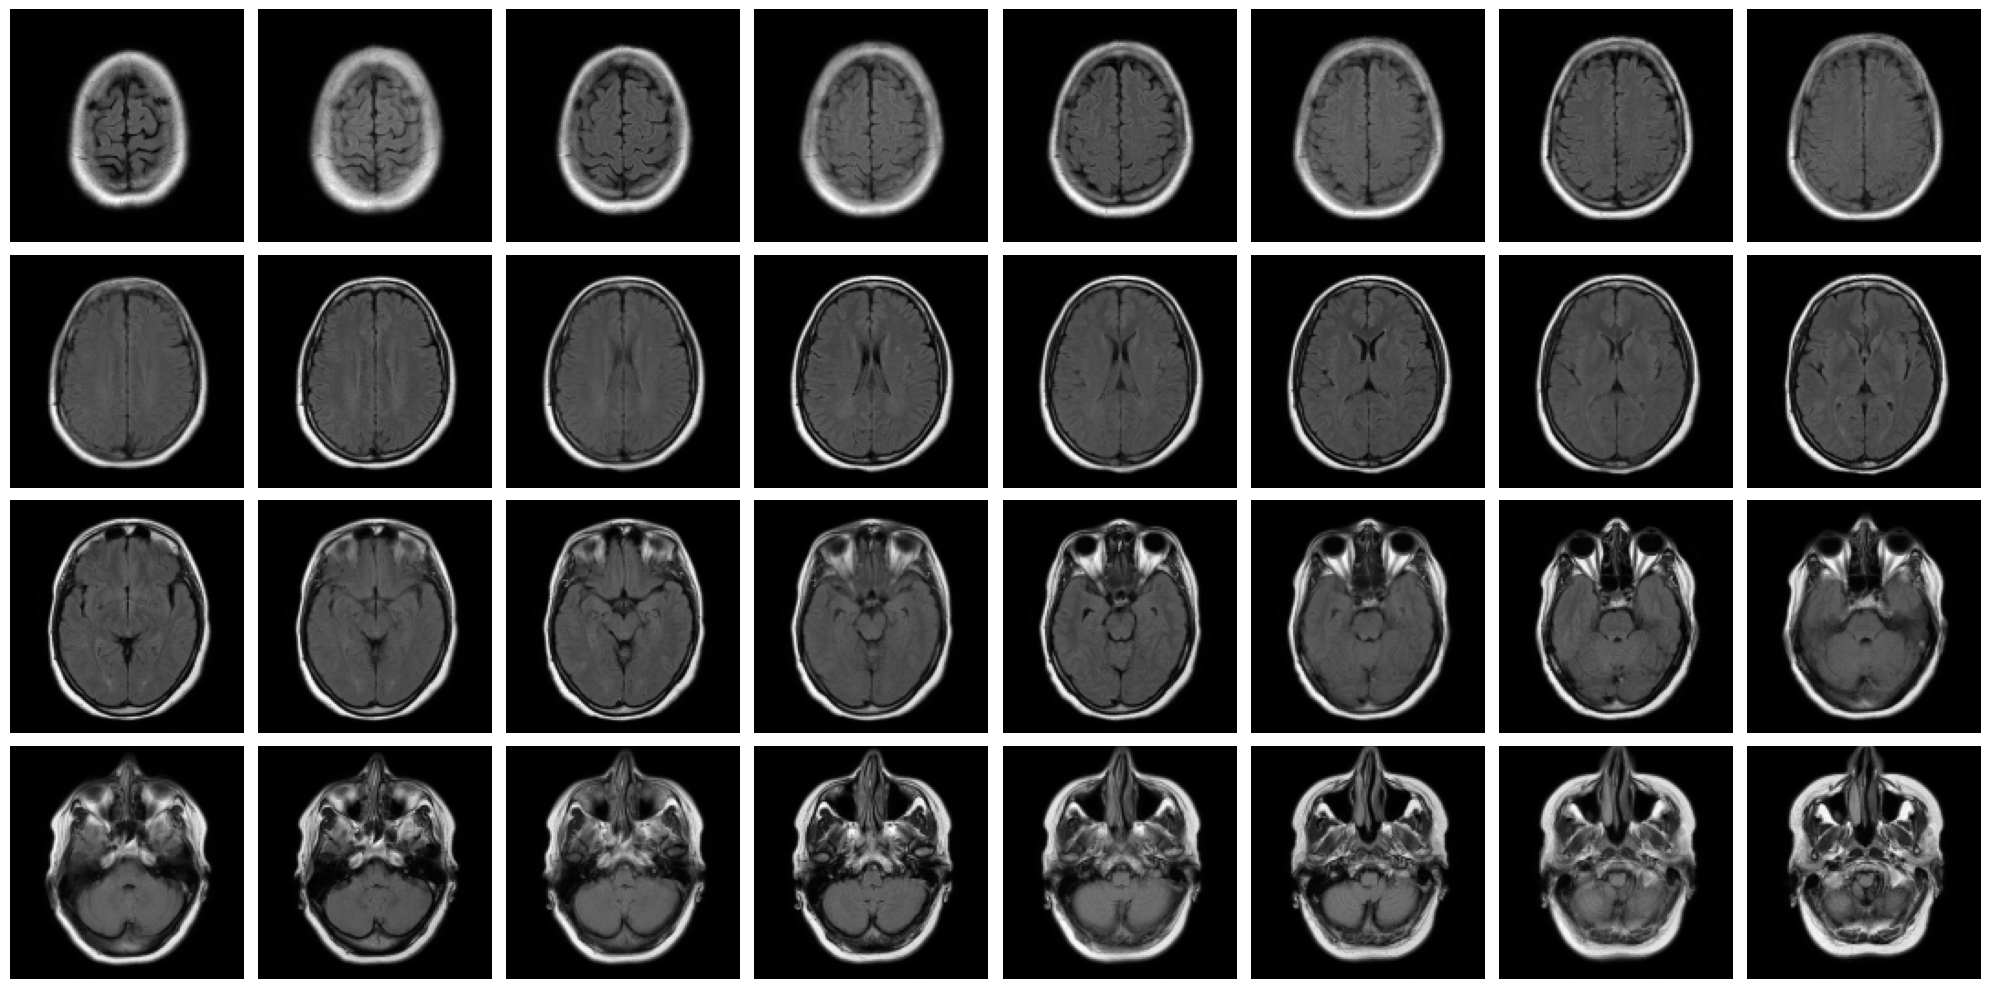

In [7]:
modality = 'T2W_FLAIR'
data_loader, train_loader, val_loader, class_weights = prepare_Dataloader(modality, batch_size=14, num_channels=1, spatial_size=(32, 128, 128), split_ratio=0.1)

In [ ]:
model = densnet_from_scratch(data_loader, train_loader, val_loader, class_weights)

epoching ...:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1/60]  -  Learning Rate = 0.0001
-------->   tn: 371   ---   fp: 444  ---   fn: 48  ---   tp: 71
Training Loss: 2.20510   ,   custom metric: 0.44659
-------->   tn: 85   ---   fp: 6  ---   fn: 13  ---   tp: 0
Validation Loss: 2.09863   ,   custom metric: 0.23352


epoching ...:   2%|▏         | 1/60 [01:06<1:05:35, 66.71s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [2/60]  -  Learning Rate = 0.0001
-------->   tn: 415   ---   fp: 400  ---   fn: 44  ---   tp: 75
Training Loss: 2.16612   ,   custom metric: 0.48190
-------->   tn: 89   ---   fp: 2  ---   fn: 13  ---   tp: 0
Validation Loss: 2.11838   ,   custom metric: 0.24451


epoching ...:   3%|▎         | 2/60 [02:13<1:04:30, 66.73s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [3/60]  -  Learning Rate = 0.0001
-------->   tn: 467   ---   fp: 348  ---   fn: 55  ---   tp: 64
Training Loss: 2.12121   ,   custom metric: 0.45099
-------->   tn: 5   ---   fp: 86  ---   fn: 0  ---   tp: 13
Validation Loss: 1.93631   ,   custom metric: 0.54656


epoching ...:   5%|▌         | 3/60 [03:21<1:03:51, 67.21s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [4/60]  -  Learning Rate = 0.0001


In [8]:
model = densnet_from_scratch(data_loader, train_loader, val_loader, class_weights)

epoching ...:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1/60]  -  Learning Rate = 5e-05
-------->   tn: 431   ---   fp: 384  ---   fn: 63  ---   tp: 56
Training Loss: 1.85000   ,   custom metric: 0.39932
-------->   tn: 3   ---   fp: 88  ---   fn: 0  ---   tp: 13
Validation Loss: 1.77201   ,   custom metric: 0.54042


epoching ...:   2%|▏         | 1/60 [01:08<1:07:37, 68.77s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [2/60]  -  Learning Rate = 5e-05
-------->   tn: 342   ---   fp: 473  ---   fn: 47  ---   tp: 72
Training Loss: 1.83980   ,   custom metric: 0.44046
-------->   tn: 6   ---   fp: 85  ---   fn: 0  ---   tp: 13
Validation Loss: 1.69940   ,   custom metric: 0.54965


epoching ...:   3%|▎         | 2/60 [02:17<1:06:43, 69.03s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [3/60]  -  Learning Rate = 5e-05
-------->   tn: 445   ---   fp: 370  ---   fn: 46  ---   tp: 73
Training Loss: 1.77867   ,   custom metric: 0.48442


epoching ...:   5%|▌         | 3/60 [03:27<1:05:42, 69.16s/it]

-------->   tn: 76   ---   fp: 15  ---   fn: 9  ---   tp: 4
Validation Loss: 1.68484   ,   custom metric: 0.41527
-------------------------------------------------------------------------------------
Epoch [4/60]  -  Learning Rate = 5e-05
-------->   tn: 427   ---   fp: 388  ---   fn: 45  ---   tp: 74
Training Loss: 1.78910   ,   custom metric: 0.48195


epoching ...:   7%|▋         | 4/60 [04:36<1:04:29, 69.11s/it]

-------->   tn: 74   ---   fp: 17  ---   fn: 9  ---   tp: 4
Validation Loss: 1.64634   ,   custom metric: 0.40476
-------------------------------------------------------------------------------------
Epoch [5/60]  -  Learning Rate = 5e-05
-------->   tn: 493   ---   fp: 322  ---   fn: 51  ---   tp: 68
Training Loss: 1.80805   ,   custom metric: 0.48053
-------->   tn: 49   ---   fp: 42  ---   fn: 3  ---   tp: 10
Validation Loss: 1.66742   ,   custom metric: 0.56731


epoching ...:   8%|▊         | 5/60 [05:46<1:03:34, 69.35s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [6/60]  -  Learning Rate = 5e-05
-------->   tn: 443   ---   fp: 372  ---   fn: 44  ---   tp: 75
Training Loss: 1.77503   ,   custom metric: 0.49296
-------->   tn: 59   ---   fp: 32  ---   fn: 3  ---   tp: 10
Validation Loss: 1.58580   ,   custom metric: 0.60623


epoching ...:  10%|█         | 6/60 [06:55<1:02:30, 69.45s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [7/60]  -  Learning Rate = 5e-05
-------->   tn: 517   ---   fp: 298  ---   fn: 46  ---   tp: 73
Training Loss: 1.61269   ,   custom metric: 0.51450


epoching ...:  12%|█▏        | 7/60 [08:04<1:01:14, 69.34s/it]

-------->   tn: 67   ---   fp: 24  ---   fn: 4  ---   tp: 9
Validation Loss: 1.53101   ,   custom metric: 0.59840
-------------------------------------------------------------------------------------
Epoch [8/60]  -  Learning Rate = 5e-05
-------->   tn: 451   ---   fp: 364  ---   fn: 40  ---   tp: 79
Training Loss: 1.72755   ,   custom metric: 0.51486


epoching ...:  13%|█▎        | 8/60 [09:13<1:00:02, 69.27s/it]

-------->   tn: 62   ---   fp: 29  ---   fn: 4  ---   tp: 9
Validation Loss: 1.59920   ,   custom metric: 0.57569
-------------------------------------------------------------------------------------
Epoch [9/60]  -  Learning Rate = 5e-05
-------->   tn: 544   ---   fp: 271  ---   fn: 41  ---   tp: 78
Training Loss: 1.65602   ,   custom metric: 0.55048


epoching ...:  15%|█▌        | 9/60 [10:22<58:48, 69.18s/it]  

-------->   tn: 32   ---   fp: 59  ---   fn: 2  ---   tp: 11
Validation Loss: 1.78985   ,   custom metric: 0.55027
-------------------------------------------------------------------------------------
Epoch [10/60]  -  Learning Rate = 5e-05
-------->   tn: 525   ---   fp: 290  ---   fn: 50  ---   tp: 69
Training Loss: 1.71159   ,   custom metric: 0.49901


epoching ...:  17%|█▋        | 10/60 [11:31<57:32, 69.05s/it]

-------->   tn: 41   ---   fp: 50  ---   fn: 2  ---   tp: 11
Validation Loss: 1.56883   ,   custom metric: 0.58080
-------------------------------------------------------------------------------------
Epoch [11/60]  -  Learning Rate = 5e-05
-------->   tn: 511   ---   fp: 304  ---   fn: 38  ---   tp: 81
Training Loss: 1.66786   ,   custom metric: 0.54968


epoching ...:  18%|█▊        | 11/60 [12:40<56:21, 69.02s/it]

-------->   tn: 27   ---   fp: 64  ---   fn: 1  ---   tp: 12
Validation Loss: 1.57428   ,   custom metric: 0.57519
-------------------------------------------------------------------------------------
Epoch [12/60]  -  Learning Rate = 5e-05
-------->   tn: 529   ---   fp: 286  ---   fn: 42  ---   tp: 77
Training Loss: 1.68147   ,   custom metric: 0.53883


epoching ...:  20%|██        | 12/60 [13:49<55:15, 69.07s/it]

-------->   tn: 44   ---   fp: 47  ---   fn: 2  ---   tp: 11
Validation Loss: 1.49457   ,   custom metric: 0.59137
-------------------------------------------------------------------------------------
Epoch [13/60]  -  Learning Rate = 5e-05
-------->   tn: 541   ---   fp: 274  ---   fn: 39  ---   tp: 80
Training Loss: 1.68720   ,   custom metric: 0.55858
-------->   tn: 55   ---   fp: 36  ---   fn: 2  ---   tp: 11
Validation Loss: 1.47261   ,   custom metric: 0.63269


epoching ...:  22%|██▏       | 13/60 [14:59<54:13, 69.22s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [14/60]  -  Learning Rate = 5e-05
-------->   tn: 495   ---   fp: 320  ---   fn: 47  ---   tp: 72
Training Loss: 1.69481   ,   custom metric: 0.50028


epoching ...:  23%|██▎       | 14/60 [16:08<52:59, 69.12s/it]

-------->   tn: 59   ---   fp: 32  ---   fn: 3  ---   tp: 10
Validation Loss: 1.45588   ,   custom metric: 0.60623
-------------------------------------------------------------------------------------
Epoch [15/60]  -  Learning Rate = 5e-05
-------->   tn: 550   ---   fp: 265  ---   fn: 45  ---   tp: 74
Training Loss: 1.63758   ,   custom metric: 0.53421


epoching ...:  25%|██▌       | 15/60 [17:17<51:52, 69.16s/it]

-------->   tn: 48   ---   fp: 43  ---   fn: 2  ---   tp: 11
Validation Loss: 1.60413   ,   custom metric: 0.60587
-------------------------------------------------------------------------------------
Epoch [16/60]  -  Learning Rate = 5e-05
-------->   tn: 576   ---   fp: 239  ---   fn: 51  ---   tp: 68
Training Loss: 1.65435   ,   custom metric: 0.51778


epoching ...:  27%|██▋       | 16/60 [18:26<50:41, 69.12s/it]

-------->   tn: 52   ---   fp: 39  ---   fn: 3  ---   tp: 10
Validation Loss: 1.48084   ,   custom metric: 0.57849
-------------------------------------------------------------------------------------
Epoch [17/60]  -  Learning Rate = 5e-05
-------->   tn: 551   ---   fp: 264  ---   fn: 34  ---   tp: 85
Training Loss: 1.56394   ,   custom metric: 0.58705


epoching ...:  28%|██▊       | 17/60 [19:35<49:31, 69.10s/it]

-------->   tn: 15   ---   fp: 76  ---   fn: 0  ---   tp: 13
Validation Loss: 1.90390   ,   custom metric: 0.57773
-------------------------------------------------------------------------------------
Epoch [18/60]  -  Learning Rate = 5e-05
-------->   tn: 552   ---   fp: 263  ---   fn: 45  ---   tp: 74
Training Loss: 1.60644   ,   custom metric: 0.53515


epoching ...:  30%|███       | 18/60 [20:44<48:21, 69.07s/it]

-------->   tn: 26   ---   fp: 65  ---   fn: 2  ---   tp: 11
Validation Loss: 1.71262   ,   custom metric: 0.53069
-------------------------------------------------------------------------------------
Epoch [19/60]  -  Learning Rate = 5e-05
-------->   tn: 533   ---   fp: 282  ---   fn: 41  ---   tp: 78
Training Loss: 1.62960   ,   custom metric: 0.54539


epoching ...:  32%|███▏      | 19/60 [21:53<47:11, 69.06s/it]

-------->   tn: 46   ---   fp: 45  ---   fn: 3  ---   tp: 10
Validation Loss: 1.58151   ,   custom metric: 0.55644
-------------------------------------------------------------------------------------
Epoch [20/60]  -  Learning Rate = 5e-05
-------->   tn: 521   ---   fp: 294  ---   fn: 35  ---   tp: 84
Training Loss: 1.59840   ,   custom metric: 0.56831


epoching ...:  33%|███▎      | 20/60 [23:03<46:07, 69.18s/it]

-------->   tn: 41   ---   fp: 50  ---   fn: 2  ---   tp: 11
Validation Loss: 1.56348   ,   custom metric: 0.58080
-------------------------------------------------------------------------------------
Epoch [21/60]  -  Learning Rate = 5e-05
-------->   tn: 589   ---   fp: 226  ---   fn: 44  ---   tp: 75
Training Loss: 1.57947   ,   custom metric: 0.55809
-------->   tn: 69   ---   fp: 22  ---   fn: 3  ---   tp: 10
Validation Loss: 1.46380   ,   custom metric: 0.65230


epoching ...:  35%|███▌      | 21/60 [24:12<45:01, 69.26s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [22/60]  -  Learning Rate = 5e-05
-------->   tn: 569   ---   fp: 246  ---   fn: 38  ---   tp: 81
Training Loss: 1.57625   ,   custom metric: 0.57680


epoching ...:  37%|███▋      | 22/60 [25:21<43:48, 69.16s/it]

-------->   tn: 42   ---   fp: 49  ---   fn: 2  ---   tp: 11
Validation Loss: 1.60577   ,   custom metric: 0.58429
-------------------------------------------------------------------------------------
Epoch [23/60]  -  Learning Rate = 5e-05
-------->   tn: 577   ---   fp: 238  ---   fn: 34  ---   tp: 85
Training Loss: 1.53032   ,   custom metric: 0.59993


epoching ...:  38%|███▊      | 23/60 [26:30<42:40, 69.21s/it]

-------->   tn: 58   ---   fp: 33  ---   fn: 2  ---   tp: 11
Validation Loss: 1.52214   ,   custom metric: 0.64492
-------------------------------------------------------------------------------------
Epoch [24/60]  -  Learning Rate = 5e-05
-------->   tn: 600   ---   fp: 215  ---   fn: 51  ---   tp: 68
Training Loss: 1.58794   ,   custom metric: 0.52983


epoching ...:  40%|████      | 24/60 [27:39<41:27, 69.09s/it]

-------->   tn: 25   ---   fp: 66  ---   fn: 2  ---   tp: 11
Validation Loss: 1.66948   ,   custom metric: 0.52747
-------------------------------------------------------------------------------------
Epoch [25/60]  -  Learning Rate = 5e-05
-------->   tn: 513   ---   fp: 302  ---   fn: 35  ---   tp: 84
Training Loss: 1.57875   ,   custom metric: 0.56471
-------->   tn: 73   ---   fp: 18  ---   fn: 3  ---   tp: 10
Validation Loss: 1.52840   ,   custom metric: 0.67445


epoching ...:  42%|████▏     | 25/60 [28:49<40:22, 69.23s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [26/60]  -  Learning Rate = 5e-05
-------->   tn: 578   ---   fp: 237  ---   fn: 38  ---   tp: 81
Training Loss: 1.54750   ,   custom metric: 0.58132


epoching ...:  43%|████▎     | 26/60 [29:58<39:11, 69.15s/it]

-------->   tn: 64   ---   fp: 27  ---   fn: 3  ---   tp: 10
Validation Loss: 1.43415   ,   custom metric: 0.62801
-------------------------------------------------------------------------------------
Epoch [27/60]  -  Learning Rate = 5e-05
-------->   tn: 585   ---   fp: 230  ---   fn: 43  ---   tp: 76
Training Loss: 1.54871   ,   custom metric: 0.56087


epoching ...:  45%|████▌     | 27/60 [31:07<38:03, 69.19s/it]

-------->   tn: 48   ---   fp: 43  ---   fn: 2  ---   tp: 11
Validation Loss: 1.52028   ,   custom metric: 0.60587
-------------------------------------------------------------------------------------
Epoch [28/60]  -  Learning Rate = 5e-05
-------->   tn: 562   ---   fp: 253  ---   fn: 36  ---   tp: 83
Training Loss: 1.55120   ,   custom metric: 0.58289


epoching ...:  47%|████▋     | 28/60 [32:16<36:50, 69.07s/it]

-------->   tn: 70   ---   fp: 21  ---   fn: 3  ---   tp: 10
Validation Loss: 1.50371   ,   custom metric: 0.65757
-------------------------------------------------------------------------------------
Epoch [29/60]  -  Learning Rate = 5e-05
-------->   tn: 551   ---   fp: 264  ---   fn: 38  ---   tp: 81
Training Loss: 1.57082   ,   custom metric: 0.56805


epoching ...:  48%|████▊     | 29/60 [33:25<35:39, 69.01s/it]

-------->   tn: 56   ---   fp: 35  ---   fn: 2  ---   tp: 11
Validation Loss: 1.51669   ,   custom metric: 0.63671
-------------------------------------------------------------------------------------
Epoch [30/60]  -  Learning Rate = 5e-05
-------->   tn: 608   ---   fp: 207  ---   fn: 39  ---   tp: 80
Training Loss: 1.47631   ,   custom metric: 0.59232


epoching ...:  50%|█████     | 30/60 [34:33<34:28, 68.96s/it]

-------->   tn: 73   ---   fp: 18  ---   fn: 4  ---   tp: 9
Validation Loss: 1.46706   ,   custom metric: 0.63004
-------------------------------------------------------------------------------------
Epoch [31/60]  -  Learning Rate = 5e-05
-------->   tn: 564   ---   fp: 251  ---   fn: 29  ---   tp: 90
Training Loss: 1.42066   ,   custom metric: 0.61714


epoching ...:  52%|█████▏    | 31/60 [35:42<33:19, 68.96s/it]

-------->   tn: 76   ---   fp: 15  ---   fn: 5  ---   tp: 8
Validation Loss: 1.55089   ,   custom metric: 0.60344
-------------------------------------------------------------------------------------
Epoch [32/60]  -  Learning Rate = 5e-05
-------->   tn: 556   ---   fp: 259  ---   fn: 31  ---   tp: 88
Training Loss: 1.46756   ,   custom metric: 0.60370


epoching ...:  53%|█████▎    | 32/60 [36:52<32:14, 69.08s/it]

-------->   tn: 65   ---   fp: 26  ---   fn: 4  ---   tp: 9
Validation Loss: 1.64632   ,   custom metric: 0.58901
-------------------------------------------------------------------------------------
Epoch [33/60]  -  Learning Rate = 5e-05
-------->   tn: 560   ---   fp: 255  ---   fn: 36  ---   tp: 83
Training Loss: 1.53218   ,   custom metric: 0.58191


epoching ...:  55%|█████▌    | 33/60 [38:01<31:05, 69.09s/it]

-------->   tn: 69   ---   fp: 22  ---   fn: 5  ---   tp: 8
Validation Loss: 1.46678   ,   custom metric: 0.56392
-------------------------------------------------------------------------------------
Epoch [34/60]  -  Learning Rate = 5e-05
-------->   tn: 590   ---   fp: 225  ---   fn: 37  ---   tp: 82
Training Loss: 1.52361   ,   custom metric: 0.59229


epoching ...:  57%|█████▋    | 34/60 [39:10<29:55, 69.05s/it]

-------->   tn: 70   ---   fp: 21  ---   fn: 4  ---   tp: 9
Validation Loss: 1.43283   ,   custom metric: 0.61346
-------------------------------------------------------------------------------------
Epoch [35/60]  -  Learning Rate = 5e-05
-------->   tn: 621   ---   fp: 194  ---   fn: 35  ---   tp: 84
Training Loss: 1.42634   ,   custom metric: 0.61897


epoching ...:  58%|█████▊    | 35/60 [40:19<28:45, 69.02s/it]

-------->   tn: 64   ---   fp: 27  ---   fn: 3  ---   tp: 10
Validation Loss: 1.61404   ,   custom metric: 0.62801
-------------------------------------------------------------------------------------
Epoch [36/60]  -  Learning Rate = 5e-05
-------->   tn: 533   ---   fp: 282  ---   fn: 31  ---   tp: 88
Training Loss: 1.52113   ,   custom metric: 0.59270


epoching ...:  60%|██████    | 36/60 [41:28<27:38, 69.10s/it]

-------->   tn: 76   ---   fp: 15  ---   fn: 5  ---   tp: 8
Validation Loss: 1.47776   ,   custom metric: 0.60344
-------------------------------------------------------------------------------------
Epoch [37/60]  -  Learning Rate = 5e-05
-------->   tn: 605   ---   fp: 210  ---   fn: 30  ---   tp: 89
Training Loss: 1.44649   ,   custom metric: 0.63395


epoching ...:  62%|██████▏   | 37/60 [42:37<26:28, 69.06s/it]

-------->   tn: 79   ---   fp: 12  ---   fn: 6  ---   tp: 7
Validation Loss: 1.54472   ,   custom metric: 0.57837
-------------------------------------------------------------------------------------
Epoch [38/60]  -  Learning Rate = 5e-05
-------->   tn: 600   ---   fp: 215  ---   fn: 31  ---   tp: 88
Training Loss: 1.35051   ,   custom metric: 0.62640


epoching ...:  63%|██████▎   | 38/60 [43:46<25:18, 69.01s/it]

-------->   tn: 71   ---   fp: 20  ---   fn: 5  ---   tp: 8
Validation Loss: 1.60762   ,   custom metric: 0.57418
-------------------------------------------------------------------------------------
Epoch [39/60]  -  Learning Rate = 5e-05
-------->   tn: 576   ---   fp: 239  ---   fn: 25  ---   tp: 94
Training Loss: 1.34239   ,   custom metric: 0.64222


epoching ...:  65%|██████▌   | 39/60 [44:55<24:08, 69.00s/it]

-------->   tn: 80   ---   fp: 11  ---   fn: 5  ---   tp: 8
Validation Loss: 1.83021   ,   custom metric: 0.63274
-------------------------------------------------------------------------------------
Epoch [40/60]  -  Learning Rate = 5e-05
-------->   tn: 582   ---   fp: 233  ---   fn: 31  ---   tp: 88
Training Loss: 1.40006   ,   custom metric: 0.61681


epoching ...:  67%|██████▋   | 40/60 [46:04<22:59, 68.98s/it]

-------->   tn: 31   ---   fp: 60  ---   fn: 2  ---   tp: 11
Validation Loss: 1.84976   ,   custom metric: 0.54697
-------------------------------------------------------------------------------------
Epoch [41/60]  -  Learning Rate = 5e-05
-------->   tn: 588   ---   fp: 227  ---   fn: 27  ---   tp: 92
Training Loss: 1.34003   ,   custom metric: 0.63902


epoching ...:  68%|██████▊   | 41/60 [47:13<21:50, 68.97s/it]

-------->   tn: 85   ---   fp: 6  ---   fn: 7  ---   tp: 6
Validation Loss: 1.90175   ,   custom metric: 0.58929
-------------------------------------------------------------------------------------
Epoch [42/60]  -  Learning Rate = 5e-05
-------->   tn: 632   ---   fp: 183  ---   fn: 23  ---   tp: 96
Training Loss: 1.29021   ,   custom metric: 0.68325


epoching ...:  70%|███████   | 42/60 [48:22<20:41, 68.97s/it]

-------->   tn: 71   ---   fp: 20  ---   fn: 4  ---   tp: 9
Validation Loss: 1.73360   ,   custom metric: 0.61879
-------------------------------------------------------------------------------------
Epoch [43/60]  -  Learning Rate = 5e-05
-------->   tn: 612   ---   fp: 203  ---   fn: 27  ---   tp: 92
Training Loss: 1.29488   ,   custom metric: 0.65225


epoching ...:  72%|███████▏  | 43/60 [49:31<19:32, 68.98s/it]

-------->   tn: 45   ---   fp: 46  ---   fn: 4  ---   tp: 9
Validation Loss: 2.08626   ,   custom metric: 0.51069
-------------------------------------------------------------------------------------
Epoch [44/60]  -  Learning Rate = 5e-05
-------->   tn: 639   ---   fp: 176  ---   fn: 29  ---   tp: 90
Training Loss: 1.24191   ,   custom metric: 0.65875


epoching ...:  73%|███████▎  | 44/60 [50:39<18:21, 68.86s/it]

-------->   tn: 82   ---   fp: 9  ---   fn: 8  ---   tp: 5
Validation Loss: 2.09605   ,   custom metric: 0.50687
-------------------------------------------------------------------------------------
Epoch [45/60]  -  Learning Rate = 5e-05
-------->   tn: 624   ---   fp: 191  ---   fn: 27  ---   tp: 92
Training Loss: 1.23464   ,   custom metric: 0.65924


epoching ...:  75%|███████▌  | 45/60 [51:48<17:12, 68.83s/it]

-------->   tn: 68   ---   fp: 23  ---   fn: 5  ---   tp: 8
Validation Loss: 1.83645   ,   custom metric: 0.55902
-------------------------------------------------------------------------------------
Epoch [46/60]  -  Learning Rate = 5e-05
-------->   tn: 646   ---   fp: 169  ---   fn: 23  ---   tp: 96
Training Loss: 1.17497   ,   custom metric: 0.69209


epoching ...:  77%|███████▋  | 46/60 [52:57<16:03, 68.85s/it]

-------->   tn: 67   ---   fp: 24  ---   fn: 5  ---   tp: 8
Validation Loss: 1.85985   ,   custom metric: 0.55426
-------------------------------------------------------------------------------------
Epoch [47/60]  -  Learning Rate = 5e-05
-------->   tn: 608   ---   fp: 207  ---   fn: 19  ---   tp: 100
Training Loss: 1.16247   ,   custom metric: 0.68810


epoching ...:  78%|███████▊  | 47/60 [54:06<14:56, 68.93s/it]

-------->   tn: 83   ---   fp: 8  ---   fn: 6  ---   tp: 7
Validation Loss: 1.98161   ,   custom metric: 0.61392
-------------------------------------------------------------------------------------
Epoch [48/60]  -  Learning Rate = 5e-05
-------->   tn: 635   ---   fp: 180  ---   fn: 24  ---   tp: 95
Training Loss: 1.16496   ,   custom metric: 0.68031


epoching ...:  80%|████████  | 48/60 [55:15<13:47, 68.95s/it]

-------->   tn: 31   ---   fp: 60  ---   fn: 3  ---   tp: 10
Validation Loss: 2.24331   ,   custom metric: 0.50549
-------------------------------------------------------------------------------------
Epoch [49/60]  -  Learning Rate = 5e-05
-------->   tn: 611   ---   fp: 204  ---   fn: 25  ---   tp: 94
Training Loss: 1.24355   ,   custom metric: 0.66124


epoching ...:  82%|████████▏ | 49/60 [56:24<12:38, 68.96s/it]

-------->   tn: 80   ---   fp: 11  ---   fn: 5  ---   tp: 8
Validation Loss: 2.08225   ,   custom metric: 0.63274
-------------------------------------------------------------------------------------
Epoch [50/60]  -  Learning Rate = 5e-05
-------->   tn: 637   ---   fp: 178  ---   fn: 26  ---   tp: 93
Training Loss: 1.17824   ,   custom metric: 0.67195


epoching ...:  83%|████████▎ | 50/60 [57:33<11:30, 69.07s/it]

-------->   tn: 61   ---   fp: 30  ---   fn: 4  ---   tp: 9
Validation Loss: 1.76586   ,   custom metric: 0.57143
-------------------------------------------------------------------------------------
Epoch [51/60]  -  Learning Rate = 5e-05
-------->   tn: 610   ---   fp: 205  ---   fn: 17  ---   tp: 102
Training Loss: 1.15337   ,   custom metric: 0.69875


epoching ...:  85%|████████▌ | 51/60 [58:42<10:20, 69.00s/it]

-------->   tn: 60   ---   fp: 31  ---   fn: 4  ---   tp: 9
Validation Loss: 1.89964   ,   custom metric: 0.56724
-------------------------------------------------------------------------------------
Epoch [52/60]  -  Learning Rate = 5e-05
-------->   tn: 648   ---   fp: 167  ---   fn: 20  ---   tp: 99
Training Loss: 1.10146   ,   custom metric: 0.70778


epoching ...:  87%|████████▋ | 52/60 [59:51<09:12, 69.02s/it]

-------->   tn: 50   ---   fp: 41  ---   fn: 5  ---   tp: 8
Validation Loss: 2.00578   ,   custom metric: 0.48587
-------------------------------------------------------------------------------------
Epoch [53/60]  -  Learning Rate = 5e-05
-------->   tn: 643   ---   fp: 172  ---   fn: 18  ---   tp: 101
Training Loss: 1.00949   ,   custom metric: 0.71410


epoching ...:  88%|████████▊ | 53/60 [1:01:00<08:03, 69.03s/it]

-------->   tn: 11   ---   fp: 80  ---   fn: 1  ---   tp: 12
Validation Loss: 3.20880   ,   custom metric: 0.52437
-------------------------------------------------------------------------------------
Epoch [54/60]  -  Learning Rate = 5e-05
-------->   tn: 669   ---   fp: 146  ---   fn: 14  ---   tp: 105
Training Loss: 0.95218   ,   custom metric: 0.75097


epoching ...:  90%|█████████ | 54/60 [1:02:09<06:53, 68.99s/it]

-------->   tn: 42   ---   fp: 49  ---   fn: 4  ---   tp: 9
Validation Loss: 2.51661   ,   custom metric: 0.50033
-------------------------------------------------------------------------------------
Epoch [55/60]  -  Learning Rate = 5e-05
-------->   tn: 677   ---   fp: 138  ---   fn: 17  ---   tp: 102
Training Loss: 0.85434   ,   custom metric: 0.74249


epoching ...:  92%|█████████▏| 55/60 [1:03:18<05:44, 68.92s/it]

-------->   tn: 82   ---   fp: 9  ---   fn: 7  ---   tp: 6
Validation Loss: 2.78531   ,   custom metric: 0.55604
-------------------------------------------------------------------------------------
Epoch [56/60]  -  Learning Rate = 5e-05
-------->   tn: 654   ---   fp: 161  ---   fn: 10  ---   tp: 109
Training Loss: 0.88480   ,   custom metric: 0.75952


epoching ...:  93%|█████████▎| 56/60 [1:04:27<04:35, 68.92s/it]

-------->   tn: 54   ---   fp: 37  ---   fn: 5  ---   tp: 8
Validation Loss: 2.54068   ,   custom metric: 0.50049
-------------------------------------------------------------------------------------
Epoch [57/60]  -  Learning Rate = 5e-05
-------->   tn: 673   ---   fp: 142  ---   fn: 17  ---   tp: 102
Training Loss: 0.95185   ,   custom metric: 0.73952


epoching ...:  95%|█████████▌| 57/60 [1:05:36<03:27, 69.01s/it]

-------->   tn: 0   ---   fp: 91  ---   fn: 0  ---   tp: 13
Validation Loss: 3.75296   ,   custom metric: 0.53125
-------------------------------------------------------------------------------------
Epoch [58/60]  -  Learning Rate = 5e-05
-------->   tn: 643   ---   fp: 172  ---   fn: 18  ---   tp: 101
Training Loss: 1.06788   ,   custom metric: 0.71410


epoching ...:  97%|█████████▋| 58/60 [1:06:45<02:18, 69.01s/it]

-------->   tn: 80   ---   fp: 11  ---   fn: 5  ---   tp: 8
Validation Loss: 1.73078   ,   custom metric: 0.63274
-------------------------------------------------------------------------------------
Epoch [59/60]  -  Learning Rate = 5e-05
-------->   tn: 688   ---   fp: 127  ---   fn: 12  ---   tp: 107
Training Loss: 0.74182   ,   custom metric: 0.77494


epoching ...:  98%|█████████▊| 59/60 [1:07:54<01:08, 68.98s/it]

-------->   tn: 81   ---   fp: 10  ---   fn: 8  ---   tp: 5
Validation Loss: 3.12132   ,   custom metric: 0.49817
-------------------------------------------------------------------------------------
Epoch [60/60]  -  Learning Rate = 5e-05
-------->   tn: 689   ---   fp: 126  ---   fn: 10  ---   tp: 109
Training Loss: 0.72838   ,   custom metric: 0.78529


epoching ...: 100%|██████████| 60/60 [1:09:03<00:00, 69.06s/it]

-------->   tn: 74   ---   fp: 17  ---   fn: 5  ---   tp: 8
Validation Loss: 2.57039   ,   custom metric: 0.59099
-------------------------------------------------------------------------------------


In [11]:
from IPython.display import FileLink

FileLink('T2W_FLAIR.pth')

/kaggle/working/T2W_FLAIR.pth

In [ ]:
model = densnet_from_scratch(data_loader, train_loader, val_loader, class_weights)

loading checkpoint ...
-------->   tn: 715   ---   fp: 191  ---   fn: 46  ---   tp: 86
whole dataset Loss: 1.49602   ,   custom metric: 0.60067


epoching ...:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1/60]  -  Learning Rate = 2e-05
-------->   tn: 581   ---   fp: 234  ---   fn: 36  ---   tp: 83
Training Loss: 1.53493   ,   custom metric: 0.59242


epoching ...:   2%|▏         | 1/60 [01:08<1:07:48, 68.95s/it]

-------->   tn: 36   ---   fp: 55  ---   fn: 2  ---   tp: 11
Validation Loss: 1.64596   ,   custom metric: 0.56364
-------------------------------------------------------------------------------------
Epoch [2/60]  -  Learning Rate = 2e-05
-------->   tn: 548   ---   fp: 267  ---   fn: 36  ---   tp: 83
Training Loss: 1.54946   ,   custom metric: 0.57612


epoching ...:   3%|▎         | 2/60 [02:17<1:06:34, 68.86s/it]

-------->   tn: 40   ---   fp: 51  ---   fn: 2  ---   tp: 11
Validation Loss: 1.60642   ,   custom metric: 0.57732
-------------------------------------------------------------------------------------
Epoch [3/60]  -  Learning Rate = 2e-05
-------->   tn: 599   ---   fp: 216  ---   fn: 34  ---   tp: 85
Training Loss: 1.46275   ,   custom metric: 0.61148


epoching ...:   5%|▌         | 3/60 [03:26<1:05:17, 68.72s/it]

-------->   tn: 35   ---   fp: 56  ---   fn: 2  ---   tp: 11
Validation Loss: 1.75504   ,   custom metric: 0.56028
-------------------------------------------------------------------------------------
Epoch [4/60]  -  Learning Rate = 2e-05
-------->   tn: 559   ---   fp: 256  ---   fn: 37  ---   tp: 82
Training Loss: 1.45881   ,   custom metric: 0.57666


epoching ...:   7%|▋         | 4/60 [04:34<1:04:04, 68.65s/it]

-------->   tn: 26   ---   fp: 65  ---   fn: 1  ---   tp: 12
Validation Loss: 1.81912   ,   custom metric: 0.57193
-------------------------------------------------------------------------------------
Epoch [5/60]  -  Learning Rate = 2e-05
-------->   tn: 590   ---   fp: 225  ---   fn: 43  ---   tp: 76
Training Loss: 1.51894   ,   custom metric: 0.56343


epoching ...:   8%|▊         | 5/60 [05:43<1:02:53, 68.60s/it]

-------->   tn: 41   ---   fp: 50  ---   fn: 2  ---   tp: 11
Validation Loss: 1.65364   ,   custom metric: 0.58080
-------------------------------------------------------------------------------------
Epoch [6/60]  -  Learning Rate = 2e-05
-------->   tn: 530   ---   fp: 285  ---   fn: 36  ---   tp: 83
Training Loss: 1.51480   ,   custom metric: 0.56770


epoching ...:  10%|█         | 6/60 [06:51<1:01:43, 68.59s/it]

-------->   tn: 38   ---   fp: 53  ---   fn: 2  ---   tp: 11
Validation Loss: 1.64574   ,   custom metric: 0.57044
-------------------------------------------------------------------------------------
Epoch [7/60]  -  Learning Rate = 2e-05
-------->   tn: 564   ---   fp: 251  ---   fn: 38  ---   tp: 81
Training Loss: 1.51536   ,   custom metric: 0.57434
-------->   tn: 58   ---   fp: 33  ---   fn: 3  ---   tp: 10
Validation Loss: 1.49167   ,   custom metric: 0.60210


epoching ...:  12%|█▏        | 7/60 [08:01<1:00:52, 68.92s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [8/60]  -  Learning Rate = 2e-05
-------->   tn: 616   ---   fp: 199  ---   fn: 36  ---   tp: 83
Training Loss: 1.46637   ,   custom metric: 0.61128


epoching ...:  13%|█▎        | 8/60 [09:10<59:38, 68.82s/it]  

-------->   tn: 30   ---   fp: 61  ---   fn: 2  ---   tp: 11
Validation Loss: 1.73775   ,   custom metric: 0.54369
-------------------------------------------------------------------------------------
Epoch [9/60]  -  Learning Rate = 2e-05
-------->   tn: 567   ---   fp: 248  ---   fn: 31  ---   tp: 88
Training Loss: 1.46755   ,   custom metric: 0.60915


epoching ...:  15%|█▌        | 9/60 [10:18<58:29, 68.81s/it]

-------->   tn: 50   ---   fp: 41  ---   fn: 3  ---   tp: 10
Validation Loss: 1.58775   ,   custom metric: 0.57100
-------------------------------------------------------------------------------------
Epoch [10/60]  -  Learning Rate = 2e-05
-------->   tn: 593   ---   fp: 222  ---   fn: 37  ---   tp: 82
Training Loss: 1.45423   ,   custom metric: 0.59387


epoching ...:  17%|█▋        | 10/60 [11:27<57:19, 68.79s/it]

-------->   tn: 36   ---   fp: 55  ---   fn: 2  ---   tp: 11
Validation Loss: 1.64835   ,   custom metric: 0.56364
-------------------------------------------------------------------------------------
Epoch [11/60]  -  Learning Rate = 2e-05
-------->   tn: 591   ---   fp: 224  ---   fn: 31  ---   tp: 88
Training Loss: 1.43455   ,   custom metric: 0.62155


epoching ...:  18%|█▊        | 11/60 [12:36<56:09, 68.77s/it]

-------->   tn: 33   ---   fp: 58  ---   fn: 2  ---   tp: 11
Validation Loss: 1.74964   ,   custom metric: 0.55359
-------------------------------------------------------------------------------------
Epoch [12/60]  -  Learning Rate = 2e-05
-------->   tn: 607   ---   fp: 208  ---   fn: 39  ---   tp: 80
Training Loss: 1.46349   ,   custom metric: 0.59178


epoching ...:  20%|██        | 12/60 [13:45<55:04, 68.83s/it]

-------->   tn: 49   ---   fp: 42  ---   fn: 3  ---   tp: 10
Validation Loss: 1.56781   ,   custom metric: 0.56731
-------------------------------------------------------------------------------------
Epoch [13/60]  -  Learning Rate = 2e-05
-------->   tn: 581   ---   fp: 234  ---   fn: 34  ---   tp: 85
Training Loss: 1.47900   ,   custom metric: 0.60198
-------->   tn: 59   ---   fp: 32  ---   fn: 3  ---   tp: 10
Validation Loss: 1.53208   ,   custom metric: 0.60623


epoching ...:  22%|██▏       | 13/60 [14:54<54:02, 68.99s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [14/60]  -  Learning Rate = 2e-05
-------->   tn: 567   ---   fp: 248  ---   fn: 36  ---   tp: 83
Training Loss: 1.51612   ,   custom metric: 0.58535


epoching ...:  23%|██▎       | 14/60 [16:03<52:49, 68.90s/it]

-------->   tn: 46   ---   fp: 45  ---   fn: 3  ---   tp: 10
Validation Loss: 1.64487   ,   custom metric: 0.55644
-------------------------------------------------------------------------------------
Epoch [15/60]  -  Learning Rate = 2e-05
-------->   tn: 603   ---   fp: 212  ---   fn: 29  ---   tp: 90
Training Loss: 1.40551   ,   custom metric: 0.63762
-------->   tn: 49   ---   fp: 42  ---   fn: 2  ---   tp: 11
Validation Loss: 1.58092   ,   custom metric: 0.60958


epoching ...:  25%|██▌       | 15/60 [17:12<51:44, 68.98s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [16/60]  -  Learning Rate = 2e-05
-------->   tn: 582   ---   fp: 233  ---   fn: 29  ---   tp: 90
Training Loss: 1.41217   ,   custom metric: 0.62634


epoching ...:  27%|██▋       | 16/60 [18:21<50:34, 68.96s/it]

-------->   tn: 59   ---   fp: 32  ---   fn: 3  ---   tp: 10
Validation Loss: 1.50388   ,   custom metric: 0.60623
-------------------------------------------------------------------------------------
Epoch [17/60]  -  Learning Rate = 2e-05
-------->   tn: 597   ---   fp: 218  ---   fn: 37  ---   tp: 82
Training Loss: 1.43589   ,   custom metric: 0.59600


epoching ...:  28%|██▊       | 17/60 [19:30<49:22, 68.89s/it]

-------->   tn: 58   ---   fp: 33  ---   fn: 4  ---   tp: 9
Validation Loss: 1.57984   ,   custom metric: 0.55907
-------------------------------------------------------------------------------------
Epoch [18/60]  -  Learning Rate = 2e-05
-------->   tn: 582   ---   fp: 233  ---   fn: 29  ---   tp: 90
Training Loss: 1.38124   ,   custom metric: 0.62634


epoching ...:  30%|███       | 18/60 [20:38<48:09, 68.80s/it]

-------->   tn: 69   ---   fp: 22  ---   fn: 4  ---   tp: 9
Validation Loss: 1.52270   ,   custom metric: 0.60829
-------------------------------------------------------------------------------------
Epoch [19/60]  -  Learning Rate = 2e-05
-------->   tn: 597   ---   fp: 218  ---   fn: 39  ---   tp: 80
Training Loss: 1.45656   ,   custom metric: 0.58638


epoching ...:  32%|███▏      | 19/60 [21:47<46:58, 68.74s/it]

-------->   tn: 44   ---   fp: 47  ---   fn: 2  ---   tp: 11
Validation Loss: 1.77813   ,   custom metric: 0.59137
-------------------------------------------------------------------------------------
Epoch [20/60]  -  Learning Rate = 2e-05
-------->   tn: 559   ---   fp: 256  ---   fn: 28  ---   tp: 91
Training Loss: 1.40101   ,   custom metric: 0.61939


epoching ...:  33%|███▎      | 20/60 [22:56<45:50, 68.77s/it]

-------->   tn: 64   ---   fp: 27  ---   fn: 4  ---   tp: 9
Validation Loss: 1.49611   ,   custom metric: 0.58448
-------------------------------------------------------------------------------------
Epoch [21/60]  -  Learning Rate = 2e-05
-------->   tn: 596   ---   fp: 219  ---   fn: 32  ---   tp: 87
Training Loss: 1.43410   ,   custom metric: 0.61945


epoching ...:  35%|███▌      | 21/60 [24:05<44:44, 68.84s/it]

-------->   tn: 67   ---   fp: 24  ---   fn: 4  ---   tp: 9
Validation Loss: 1.51589   ,   custom metric: 0.59840
-------------------------------------------------------------------------------------
Epoch [22/60]  -  Learning Rate = 2e-05
-------->   tn: 603   ---   fp: 212  ---   fn: 32  ---   tp: 87
Training Loss: 1.39195   ,   custom metric: 0.62326


epoching ...:  37%|███▋      | 22/60 [25:14<43:36, 68.86s/it]

-------->   tn: 43   ---   fp: 48  ---   fn: 2  ---   tp: 11
Validation Loss: 1.71704   ,   custom metric: 0.58782
-------------------------------------------------------------------------------------
Epoch [23/60]  -  Learning Rate = 2e-05
-------->   tn: 600   ---   fp: 215  ---   fn: 26  ---   tp: 93
Training Loss: 1.31842   ,   custom metric: 0.65029
-------->   tn: 61   ---   fp: 30  ---   fn: 3  ---   tp: 10
Validation Loss: 1.61006   ,   custom metric: 0.61470


epoching ...:  38%|███▊      | 23/60 [26:23<42:30, 68.94s/it]

                                           <<< ==== Saved new best model ==== >>>
-------------------------------------------------------------------------------------
Epoch [24/60]  -  Learning Rate = 2e-05
-------->   tn: 618   ---   fp: 197  ---   fn: 40  ---   tp: 79
Training Loss: 1.43598   ,   custom metric: 0.59306
-------->   tn: 634   ---   fp: 181  ---   fn: 29  ---   tp: 90
Training Loss: 1.31679   ,   custom metric: 0.65566


epoching ...:  42%|████▏     | 25/60 [28:40<40:07, 68.80s/it]

-------->   tn: 67   ---   fp: 24  ---   fn: 4  ---   tp: 9
Validation Loss: 1.54822   ,   custom metric: 0.59840
-------------------------------------------------------------------------------------
Epoch [26/60]  -  Learning Rate = 2e-05
-------->   tn: 591   ---   fp: 224  ---   fn: 20  ---   tp: 99
Training Loss: 1.30102   ,   custom metric: 0.67388


epoching ...:  43%|████▎     | 26/60 [29:49<38:57, 68.75s/it]

-------->   tn: 66   ---   fp: 25  ---   fn: 4  ---   tp: 9
Validation Loss: 1.63804   ,   custom metric: 0.59365
-------------------------------------------------------------------------------------
Epoch [27/60]  -  Learning Rate = 2e-05
-------->   tn: 620   ---   fp: 195  ---   fn: 32  ---   tp: 87
Training Loss: 1.35468   ,   custom metric: 0.63286


epoching ...:  45%|████▌     | 27/60 [30:57<37:48, 68.74s/it]

-------->   tn: 46   ---   fp: 45  ---   fn: 3  ---   tp: 10
Validation Loss: 1.73349   ,   custom metric: 0.55644
-------------------------------------------------------------------------------------
Epoch [28/60]  -  Learning Rate = 2e-05
-------->   tn: 604   ---   fp: 211  ---   fn: 26  ---   tp: 93
Training Loss: 1.32650   ,   custom metric: 0.65251


epoching ...:  47%|████▋     | 28/60 [32:06<36:38, 68.71s/it]

-------->   tn: 29   ---   fp: 62  ---   fn: 1  ---   tp: 12
Validation Loss: 2.15588   ,   custom metric: 0.58175
-------------------------------------------------------------------------------------
Epoch [29/60]  -  Learning Rate = 2e-05
-------->   tn: 607   ---   fp: 208  ---   fn: 27  ---   tp: 92
Training Loss: 1.28362   ,   custom metric: 0.64942


In [9]:
shutil.rmtree('/kaggle/working/T2W_FLAIR')

## Resnet

### from scratch

In [ ]:
from monai.networks.nets import resnet152
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from tqdm import tqdm


def resnet_from_scratch(train_loader, val_loader, class_weights):

    model = resnet152(spatial_dims=3, n_input_channels=1, num_classes=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    class_weights = class_weights.to(device)

    def calculate_metrics(predictions, labels):
        y_true = np.array(labels)
        y_pred = np.array(predictions)
        auc = roc_auc_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred.round(), average='binary', zero_division=1)
        recall = recall_score(y_true, y_pred.round(), average='binary', zero_division=1)

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        print('------->   tn:',tn,'  ---   fp:', fp,' ---   fn:', fn,' ---   tp:', tp)

        return (auc + (precision + recall)/2)/2

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

    best_metric = 0.0
    num_epochs = 60
    for epoch in tqdm(range(num_epochs),'epoching ...'):
        model.train()
        running_loss = 0.0
        all_predictions = []
        all_labels = []

        for batch in train_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Collect predictions and labels
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Convert lists to numpy arrays
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)

        # Calculate metrics for the current epoch
        print('training confusion matrix:')
        c_metric = calculate_metrics(all_predictions, all_labels)

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_loader):.4f}")
        print(f"training custom metric is : {c_metric}")

        model.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_predictions.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

            val_predictions = np.array(val_predictions)
            val_labels = np.array(val_labels)
            print('validation confusion matrix:')
            val_c_metric = calculate_metrics(val_predictions, val_labels)

            scheduler.step(val_c_metric)

            if val_c_metric > best_metric:
                  best_metric = val_c_metric
                  torch.save(model.state_dict(), f'/kaggle/working/{modality}.pth')              # Save the model
                  print(" <<< --- Saved new best model --- >>>")
            print(f"Validation Loss: {val_running_loss/len(val_loader):.4f}")
            print(f"validation custom metric is : {val_c_metric}")

    print("Finished Training")

In [ ]:
modality = 'T1W_SE'
data_loader, train_loader, val_loader, class_weights = prepare_Dataloader(modality,batch_size=1, num_channels=1, split_ratio=0.3)
resnet_from_scratch(train_loader, val_loader, class_weights)

In [ ]:
shutil.rmtree('/kaggle/working/T1W_SE')

import torch
torch.cuda.empty_cache()

## combined model

### with MLP

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model = nn.Sequential(*list(self.model.children())[:-1])  # Remove last layer (classification layer)

    def forward(self, x):
        x = self.model(x)
        x = torch.flatten(x, 1)  # Flatten the output tensor
        return x

# Define the combined model that will take 20 inputs
class CombinedModel(nn.Module):
    def __init__(self, num_models=20, feature_dim=512):
        super(CombinedModel, self).__init__()
        self.num_models = num_models

        self.base_model = BaseModel()

        self.fc1 = nn.Linear(feature_dim * num_models, 1024)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 1)


    def forward(self, x):
        batch_size = x.size(0)
        features = []
        for i in range(self.num_models):
            slice_i = x[:, :, i, :, :]
            slice_i = slice_i.view(batch_size, x.size(1), x.size(3), x.size(4))
            features.append(self.base_model(slice_i))

        # Concatenate the features from all base models
        x = torch.cat(features, dim=1)

        # Pass through the fully connected layers
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### with AttentionBlock

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.model = models.resnet18(pretrained=True)

        # Freeze the first half of the layers
        num_layers = len(list(self.model.children()))
        num_layers_to_freeze = num_layers // 2

        for idx, child in enumerate(self.model.children()):
            if idx < num_layers_to_freeze:
                for param in child.parameters():
                    param.requires_grad = False

        # Remove the final classification layer
        self.model = nn.Sequential(*list(self.model.children())[:-1])

    def forward(self, x):
        x = self.model(x)
        x = torch.flatten(x, 1)  # Flatten the output tensor
        return x

class AttentionBlock(nn.Module):
    def __init__(self, num_models, feature_dim):
        super(AttentionBlock, self).__init__()
        self.attention_weights = nn.Parameter(torch.randn(num_models, feature_dim))

    def forward(self, features):
        # features: Tensor of shape (batch_size, num_models, feature_dim)
        attention_scores = torch.matmul(features, self.attention_weights.transpose(0, 1))  # (batch_size, num_models, num_models)
        attention_scores = F.softmax(attention_scores, dim=1)  # Softmax along the num_models dimension

        # Apply attention scores to features
        weighted_features = torch.matmul(attention_scores.transpose(1, 2), features)  # (batch_size, num_models, feature_dim)
        aggregated_features = torch.sum(weighted_features, dim=1)  # (batch_size, feature_dim)

        return aggregated_features

# Define the combined model that will take 20 inputs
class CombinedModel(nn.Module):
    def __init__(self, num_models=20, feature_dim=512):
        super(CombinedModel, self).__init__()
        self.num_models = num_models

        self.base_model = BaseModel()
        self.attention_block = AttentionBlock(num_models, feature_dim)
        self.fc = nn.Linear(feature_dim, 1)

    def forward(self, x):
        batch_size = x.size(0)
        features = []
        for i in range(self.num_models):
            slice_i = x[:, :, i, :, :]
            slice_i = slice_i.view(batch_size, x.size(1), x.size(3), x.size(4))
            features.append(self.base_model(slice_i))

        # Stack the features from all base models
        features = torch.stack(features, dim=1)  # (batch_size, num_models, feature_dim)

        # Pass through the attention block
        x = self.attention_block(features)

        # Pass through the final fully connected layer
        x = self.fc(x)

        return x


In [ ]:
modality = 'T1W_SE'
model = CombinedModel(num_models=20, feature_dim=512)
data_loader, train_loader, val_loader, class_weights = prepare_Dataloader(modality, batch_size=12, num_channels=3, split_ratio=0.3, num_slices=20, w=224, h=224)

## efficient net

In [ ]:
from monai.networks.nets import EfficientNetBN
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from tqdm import tqdm


def efficientnet_from_scratch(train_loader, val_loader, class_weights):

    model = EfficientNetBN(model_name='efficientnet-b7', spatial_dims=3, in_channels=1, num_classes=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    class_weights = class_weights.to(device)

    def calculate_metrics(predictions, labels):
        y_true = np.array(labels)
        y_pred = np.array(predictions)
        auc = roc_auc_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred.round(), average='binary', zero_division=1)
        recall = recall_score(y_true, y_pred.round(), average='binary', zero_division=1)

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        print('------->   tn:',tn,'  ---   fp:', fp,' ---   fn:', fn,' ---   tp:', tp)

        return (auc + (precision + recall)/2)/2

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

    best_metric = 0.0
    num_epochs = 60
    for epoch in tqdm(range(num_epochs),'epoching ...'):
        model.train()
        running_loss = 0.0
        all_predictions = []
        all_labels = []

        for batch in train_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Collect predictions and labels
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Convert lists to numpy arrays
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)

        # Calculate metrics for the current epoch
        print('training confusion matrix:')
        c_metric = calculate_metrics(all_predictions, all_labels)

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_loader):.4f}")
        print(f"training custom metric is : {c_metric}")

        model.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_predictions.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

            val_predictions = np.array(val_predictions)
            val_labels = np.array(val_labels)
            print('validation confusion matrix:')
            val_c_metric = calculate_metrics(val_predictions, val_labels)

            scheduler.step(val_c_metric)

            if val_c_metric > best_metric:
                  best_metric = val_c_metric
                  torch.save(model.state_dict(), f'/kaggle/working/{modality}.pth')              # Save the model
                  print(" <<< --- Saved new best model --- >>>")
            print(f"Validation Loss: {val_running_loss/len(val_loader):.4f}")
            print(f"validation custom metric is : {val_c_metric}")

    print("Finished Training")

In [ ]:
modality = 'T1W_SE'
data_loader, train_loader, val_loader, class_weights = prepare_Dataloader(modality, batch_size=2, num_channels=1, split_ratio=0.3)
efficientnet_from_scratch(train_loader, val_loader, class_weights)

In [ ]:
shutil.rmtree('/kaggle/working/T1W_SE')

import torch
torch.cuda.empty_cache()

## MVit

In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

def mvit_from_scratch(train_loader, val_loader, class_weights):

    class CustomHead(nn.Module):
        def __init__(self, in_features):
            super(CustomHead, self).__init__()
            self.fc1 = nn.Linear(in_features, 256)
            self.relu = nn.ReLU()
            self.dropout1 = nn.Dropout(p=0.1)
            self.fc2 = nn.Linear(256, 64)
            self.relu = nn.ReLU()
            self.dropout2 = nn.Dropout(p=0.1)
            self.fc3 = nn.Linear(64, 16)
            self.relu = nn.ReLU()
            self.fc4 = nn.Linear(16, 2)

        def forward(self, x):
            x = self.fc1(x)
            x = self.relu(x)
            x = self.dropout1(x)
            x = self.fc2(x)
            x = self.relu(x)
            x = self.dropout2(x)
            x = self.fc3(x)
            x = self.relu(x)
            x = self.fc4(x)
            return x

    model = torch.hub.load('facebookresearch/pytorchvideo', 'mvit_base_32x3', pretrained=True)
    model.head.proj = CustomHead(in_features=768)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    class_weights = class_weights.to(device)

    def calculate_metrics(predictions, labels):
        y_true = np.array(labels)
        y_pred = np.array(predictions)
        auc = roc_auc_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred.round(), average='binary', zero_division=1)
        recall = recall_score(y_true, y_pred.round(), average='binary', zero_division=1)

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        print('------->   tn:',tn,'  ---   fp:', fp,' ---   fn:', fn,' ---   tp:', tp)

        return (auc + (precision + recall)/2)/2

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

    best_metric = 0.0
    num_epochs = 60
    for epoch in tqdm(range(num_epochs),'epoching ...'):
        model.train()
        running_loss = 0.0
        all_predictions = []
        all_labels = []

        for batch in train_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Collect predictions and labels
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Convert lists to numpy arrays
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)

        # Calculate metrics for the current epoch
        print('training confusion matrix:')
        c_metric = calculate_metrics(all_predictions, all_labels)

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_loader):.4f}")
        print(f"training custom metric is : {c_metric}")

        model.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_predictions.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

            val_predictions = np.array(val_predictions)
            val_labels = np.array(val_labels)
            print('validation confusion matrix:')
            val_c_metric = calculate_metrics(val_predictions, val_labels)

            scheduler.step(val_c_metric)

            if val_c_metric > best_metric:
                  best_metric = val_c_metric
                  torch.save(model.state_dict(), f'/kaggle/working/{modality}.pth')              # Save the model
                  print(" <<< ====== Saved new best model ====== >>>")
            print(f"Validation Loss: {val_running_loss/len(val_loader):.4f}")
            print(f"validation custom metric is : {val_c_metric}")
            print('-------------------------------------------------------------------------------------')

    print("Finished Training")

In [ ]:
modality = 'T1W_SE'
data_loader, train_loader, val_loader, class_weights = prepare_Dataloader(modality, batch_size=2, num_channels=3, split_ratio=0.2, augment='False', spatial_size=(32, 224, 224))
mvit_from_scratch(train_loader, val_loader, class_weights)

In [ ]:
shutil.rmtree('/kaggle/working/T1W_SE')

import torch
torch.cuda.empty_cache()

## slowfast

In [4]:
!pip install fvcore av

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 52.3 MB/s eta 0:00:00:00:0100:01
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=46e807de38286b8578a3a5adee3b59efa426eadb36645a5358695159b00394ac
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=b4d97166005589f6573450b7441ade75cc3d934badb00c835753dfc8f2bfa2b7
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [9]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import torch.nn as nn
from torch.nn import LayerNorm
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

def slowfast_from_scratch(train_loader, val_loader, class_weights, version):

    if version == 'r50':
        model = torch.hub.load('facebookresearch/pytorchvideo', 'slow_r50', pretrained=True)
    elif version == 'r101':
        model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r101', pretrained=True)

    model.blocks[-1].proj =  nn.Linear(in_features=model.blocks[-1].proj.in_features, out_features=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    class_weights = class_weights.to(device)

    class SelectSlices(Transform):
        def __init__(self, num_slices: int = 8):
            self.num_slices = num_slices
        def __call__(self, images: torch.Tensor):
            batch_size, channels, depth, height, width = images.shape
            indices = torch.linspace(0, depth - 1, self.num_slices).long()
            selected_slices = images[:, :, indices, :, :]
            return selected_slices

    transform = SelectSlices(num_slices=8)

    def calculate_metrics(predictions, labels):
        y_true = np.array(labels)
        y_pred = np.array(predictions)
        auc = roc_auc_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred.round(), average='binary', zero_division=1)
        recall = recall_score(y_true, y_pred.round(), average='binary', zero_division=1)

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        print('------->   tn:',tn,'  ---   fp:', fp,' ---   fn:', fn,' ---   tp:', tp)

        return (auc + (precision + recall)/2)/2

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

    best_checkpoint_path = f"{modality}.pth"
    if os.path.exists(best_checkpoint_path):
        print('loading  checkpoint ....')
        checkpoint = torch.load(best_checkpoint_path)
        model.load_state_dict(checkpoint)
        model.eval()
        val_running_loss = 0.0
        val_predictions = []
        val_labels = []
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device)

                if version == 'r50':
                    outputs = model(images)
                elif version =='r101':
                    slow_images = transform(images).to(device)
                    inputs = [ slow_images ,  images ]
                    outputs = model(inputs)

                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_predictions.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

            val_predictions = np.array(val_predictions)
            val_labels = np.array(val_labels)

            val_c_metric = calculate_metrics(val_predictions, val_labels)
            best_metric = val_c_metric
            print(f"Validation Loss: {val_running_loss/len(val_loader):.4f}, custom metric is : {val_c_metric}")
            print('----------------------------------------------------------------------------------------------')

    best_metric = 0.0
    num_epochs = 60
    for epoch in tqdm(range(num_epochs),'epoching ...'):
        model.train()
        running_loss = 0.0
        all_predictions = []
        all_labels = []

        for batch in train_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            if version == 'r50':
                outputs = model(images)
            elif version =='r101':
                slow_images = transform(images).to(device)
                inputs = [ slow_images ,  images ]
                outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)
        custom_metric = calculate_metrics(all_predictions, all_labels)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_loader):.4f}, custom metric is : {custom_metric}")

        model.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device)

                if version == 'r50':
                    outputs = model(images)
                elif version =='r101':
                    slow_images = transform(images).to(device)
                    inputs = [ slow_images ,  images ]
                    outputs = model(inputs)

                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_predictions.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

            val_predictions = np.array(val_predictions)
            val_labels = np.array(val_labels)

            val_c_metric = calculate_metrics(val_predictions, val_labels)
            #scheduler.step(val_c_metric)

            print(f"Validation Loss: {val_running_loss/len(val_loader):.4f}, custom metric is : {val_c_metric}")
            print('----------------------------------------------------------------------------------------------')

            if val_c_metric > best_metric:
                  best_metric = val_c_metric
                  torch.save(model.state_dict(), f'/kaggle/working/{modality}.pth')              # Save the model
                  print(" <<< ====== Saved new best model ====== >>>")


    print("Finished Training")

#### r_50

In [ ]:
modality = 'T1W_SE'
data_loader, train_loader, val_loader, class_weights = prepare_Dataloader(modality, batch_size=2)
slowfast_from_scratch(train_loader, val_loader, class_weights, version='r50')

#### r_101

In [ ]:

slowfast_from_scratch(train_loader, val_loader, class_weights, version='r101')

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
/tmp/ipykernel_36/3002365528.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint =

------->   tn: 182   ---   fp: 0  ---   fn: 25  ---   tp: 0
load the check point ....
Validation Loss: 0.5248, custom metric is : 0.5
----------------------------------------------------------------------------------------------


epoching ...:   0%|          | 0/60 [00:00<?, ?it/s]

------->   tn: 728   ---   fp: 0  ---   fn: 98  ---   tp: 0
Epoch [1/60], Training Loss: 0.5152, custom metric is : 0.5
------->   tn: 182   ---   fp: 0  ---   fn: 25  ---   tp: 0
Validation Loss: 0.5194, custom metric is : 0.5
----------------------------------------------------------------------------------------------


epoching ...:   2%|▏         | 1/60 [10:07<9:57:41, 607.83s/it]

 <<< ====== Saved new best model ====== >>>


In [74]:
shutil.rmtree('/kaggle/working/T1W_SE')

import torch
torch.cuda.empty_cache()

# for T2

In [ ]:
modality = 'T2W_TSE'
data_loader, train_loader, val_loader, class_weights = prepare_Dataloader(modality, batch_size=2, num_channels=3)
slowfast_from_scratch(train_loader, val_loader, class_weights)

In [ ]:
from IPython.display import FileLink

FileLink('T2W_TSE.pth')

# for Flair

In [ ]:
modality = 'T2W_FLAIR'
data_loader, train_loader, val_loader, class_weights = prepare_Dataloader(modality, batch_size=2, num_channels=3)
slowfast_from_scratch(train_loader, val_loader, class_weights)